In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import scipy
import time
import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
from collections import Counter
from Bio import Align
from Bio import SeqIO
from Bio.Align import PairwiseAligner
import pysam
from difflib import SequenceMatcher
import scipy.sparse as sp

sc.settings.verbosity = 2
# sc.logging.print_header()

# Load in exo vs endo adata

In [2]:
%%time

fpath = "/scratch/indikar_root/indikar1/shared_data/HYB/endo_vs_exo/processed_all_groups_wExoEndo.h5ad"

adata = sc.read_h5ad(fpath)
adata

CPU times: user 54.7 ms, sys: 6.58 s, total: 6.64 s
Wall time: 3min 59s


AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [3]:
vdf = adata.var.loc[['MYOD1_endo', 'MYOD1_exo']].copy()

vdf = vdf[['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']]

display(vdf)


# plt.rcParams['figure.figsize'] = 5, 4
# plt.rcParams['figure.dpi'] = 200
# fig, axs = plt.subplots(2, 3)

# for i, col in enumerate(vdf.columns):
#     ax = axs[i // 3, i % 3]
#     plot_data = vdf[[col]].reset_index().rename(columns={'index': 'Gene', col: 'Value'})
    
#     sns.barplot(
#         data=plot_data,
#         x='Gene',
#         y='Value',
#         hue='Gene',
#         ax=ax,
#         palette='pastel',
#         legend=False,
#         width=0.4,
#         ec='k',
#         linewidth=0.75,
#     )
    
#     ax.set_title(col.replace('_', ' '), fontsize=10)
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_xticklabels(['endo', 'exo'])
#     ax.tick_params(axis='y', labelsize=8)

# sns.despine()
# plt.tight_layout()
# plt.show()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MYOD1_endo,5774,6.325392,1.991347,63.799373,100890.0,11.521796
MYOD1_exo,5993,11.192476,2.500819,62.426332,178520.0,12.092462


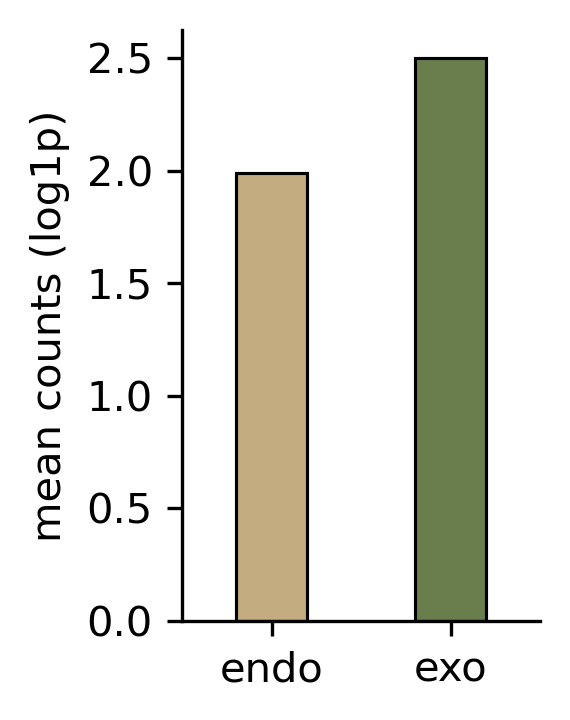

In [15]:
plt.rcParams['figure.figsize'] = 2, 2.5 
plt.rcParams['figure.dpi'] = 300

# plot_col = 'n_cells_by_counts' # 2, 2.5
# plot_col = 'total_counts' # 2.25, 2.5
plot_col = 'log1p_mean_counts'

plot_df = vdf[[plot_col]].reset_index().rename(columns={'index': 'Gene', plot_col: 'Value'})

sns.barplot(
    data=plot_df,
    x='Gene',
    y='Value',
    hue='Gene',
    palette=['#CEB175', '#6C8645'],
    legend=False,
    width=0.4,
    ec='k',
    linewidth=0.75,
)

plt.title('')
# plt.ylabel('cells (count > 0)')
# plt.ylabel('total counts')
plt.ylabel('mean counts (log1p)')
plt.xlabel('')

plt.gca().set_xticklabels(['endo', 'exo'])

sns.despine()
plt.tight_layout()
plt.show()

In [20]:
gene = 'MYOD1_endo'

plot_title = gene.split('_')[1]

plot_title

'endo'

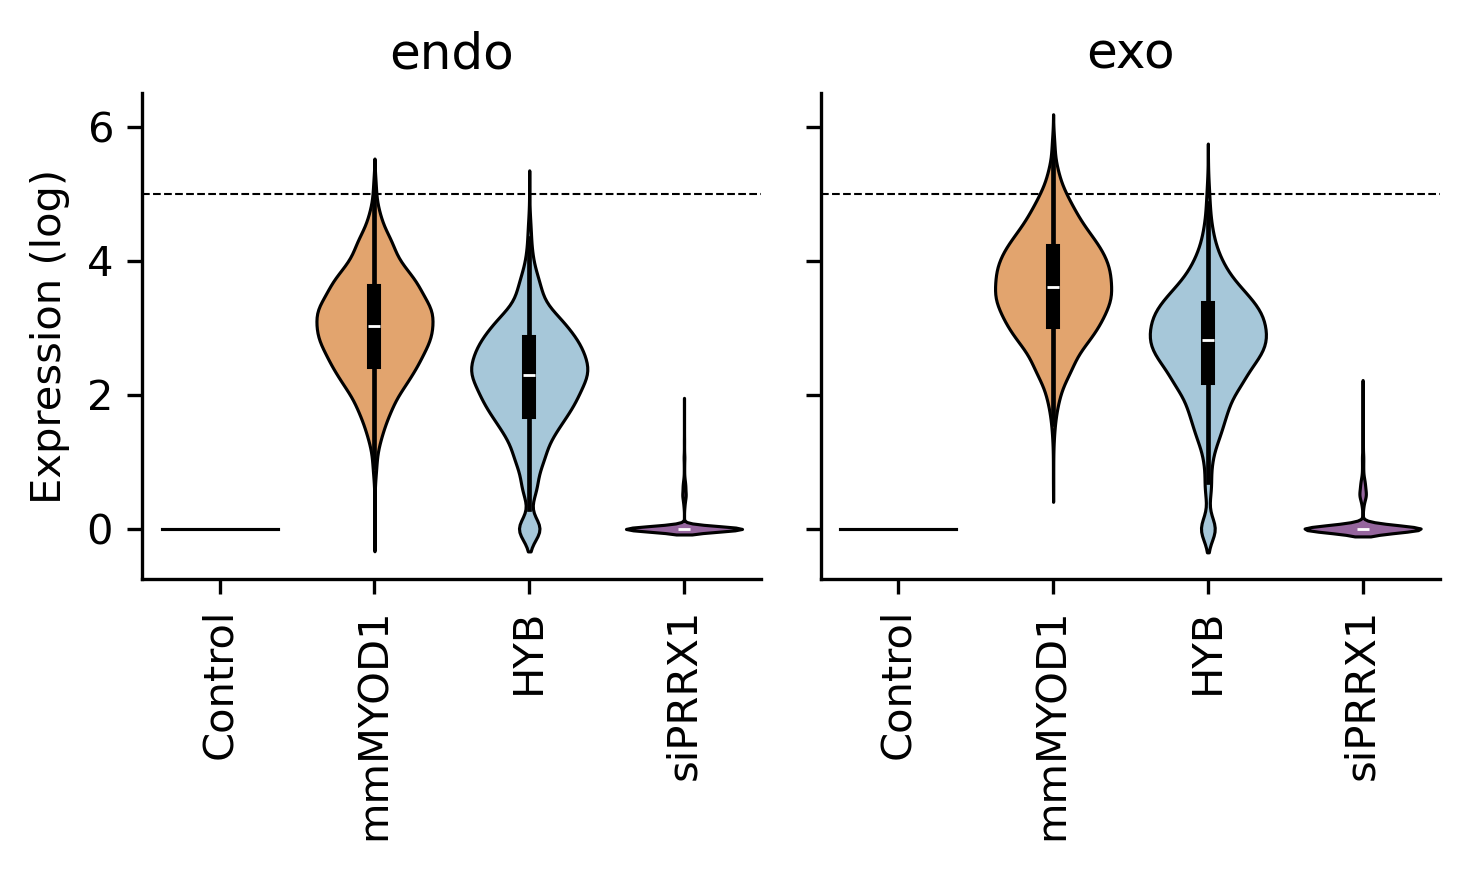

In [26]:
condition_map = {
    "Control": "Control",
    "siPRRX1/mmMYOD1": "HYB",
    "siPRRX1": "siPRRX1",
    "mmMYOD1": "mmMYOD1",
}

adata.obs['condition'] = adata.obs['pooled_condition'].map(condition_map)


genes_to_plot = ['MYOD1_endo', 'MYOD1_exo']

plot_order = ['Control', 'mmMYOD1', 'HYB', 'siPRRX1']

palette = [
    'silver',
    '#F5A35B', # orange
    '#9B5CA6', # blue
    '#9ECAE1', # purple
]

fig, axes = plt.subplots(1, 2, figsize=(5, 3), dpi=300, sharey=True)

layer = 'log_norm'

for i, gene in enumerate(genes_to_plot):
    adata.X = adata.layers[layer].copy()
    gene_exp = adata[:, gene].X.toarray().flatten()
    groups = adata.obs['condition']
    data = pd.DataFrame({'expression': gene_exp, 'group': groups})

    sns.violinplot(
        data=data,
        x='group',
        y='expression',
        hue='group',
        order=plot_order,
        width=0.75,
        linewidth=0.75,
        linecolor='k',
        palette=palette,
        ax=axes[i],
        legend=False,
    )
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=90)
    
    axes[i].set_title(gene.split('_')[1])
    
    if layer == 'log_norm':
        axes[i].set_ylabel("Expression (log)")
        axes[i].axhline(y=5, ls='--', color='k', lw=0.5, zorder=0)
    else:
        axes[i].set_ylabel("Raw counts")
    # axes[i].set_title(gene)
    axes[i].set_ylim([-0.75, 6.5])
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

count    5993.000000
mean        0.565769
std         0.190281
min         0.000000
25%         0.481481
50%         0.566667
75%         0.660714
max         1.000000
Name: MYOD1_endo_exo_ratio, dtype: float64

(15950, 37)
(5993, 37)


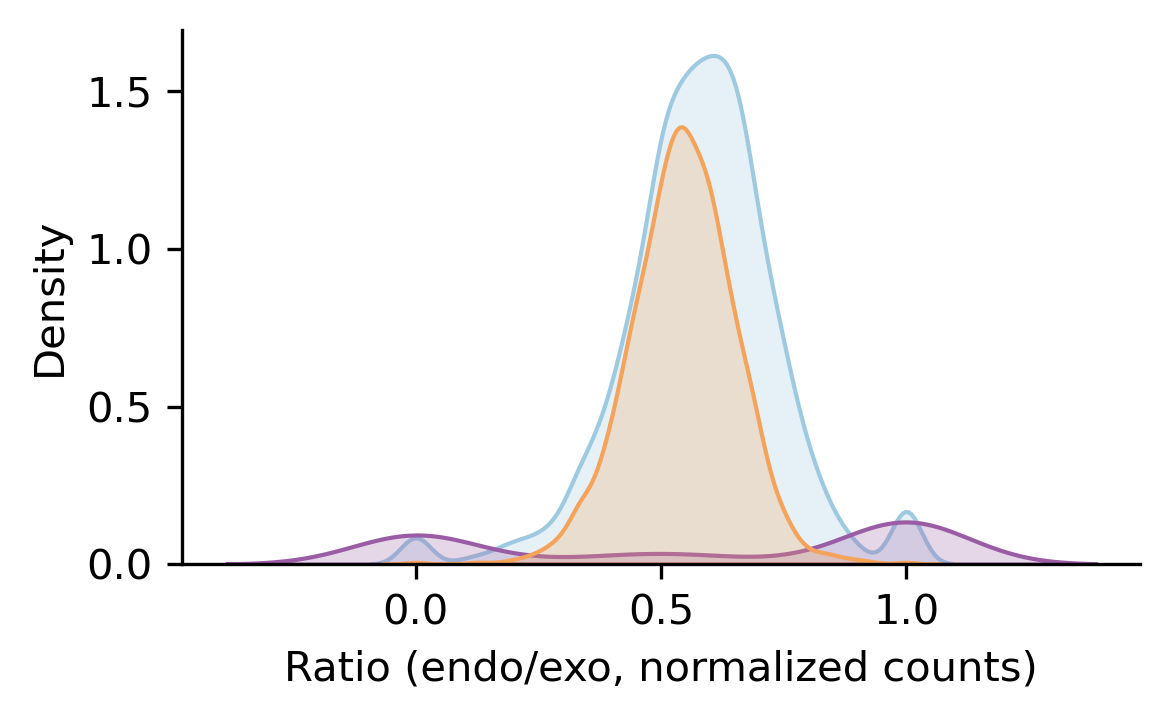

In [29]:
# compute ratio of exo and endo
endo_idx = adata.var_names.get_loc('MYOD1_endo')
exo_idx  = adata.var_names.get_loc('MYOD1_exo')

layer = 'norm'

expr = adata.layers[layer]
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

endo_exp = expr[:, endo_idx]
exo_exp  = expr[:, exo_idx]

# Calculate ratio safely (NaN where exo is 0)
ratio = np.divide(endo_exp, exo_exp, out=np.full_like(endo_exp, np.nan), where=exo_exp!=0)

adata.obs['MYOD1_endo_exo_ratio'] = ratio

# display(adata_expanded.obs.head())
display(adata.obs['MYOD1_endo_exo_ratio'].describe())


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2.5

df = adata.obs.copy()
print(df.shape)
df = adata.obs.dropna(subset='MYOD1_endo_exo_ratio')
print(df.shape)

sns.kdeplot(
    # data=adata_expanded.obs,
    data=df,
    x='MYOD1_endo_exo_ratio',
    fill=True,
    hue='pooled_condition',
    palette=palette,
    legend=False,
)

plt.xlabel("Ratio (endo/exo, normalized counts)")

sns.despine()
plt.tight_layout()
plt.show()

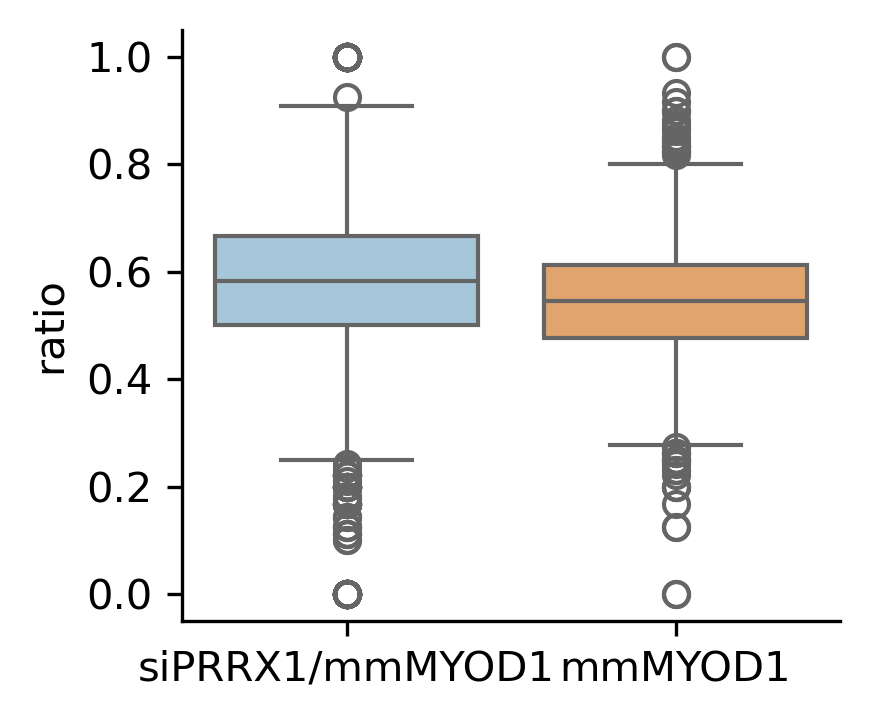

In [41]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2.5

plot_df = df[df['pooled_condition'].isin(['mmMYOD1', 'siPRRX1/mmMYOD1'])].copy()

plot_df['pooled_condition'] = plot_df['pooled_condition'].astype(str)

sns.boxplot(
    data=plot_df,
    x='pooled_condition',
    y='MYOD1_endo_exo_ratio',
    hue='pooled_condition',
    palette=['#9ECAE1', '#F5A35B'],
    legend=False,
)

plt.xlabel("")
plt.ylabel("ratio")

sns.despine()
plt.tight_layout()
plt.show()

In [33]:
df['pooled_condition'].value_counts()

pooled_condition
siPRRX1/mmMYOD1    3357
mmMYOD1            2109
siPRRX1             527
Control               0
Name: count, dtype: int64

In [31]:
from scipy.stats import ks_2samp, mannwhitneyu

In [34]:
# Split ratios by group
group1 = df[df['pooled_condition'] == 'mmMYOD1']['MYOD1_endo_exo_ratio'].dropna()
group2 = df[df['pooled_condition'] == 'siPRRX1/mmMYOD1']['MYOD1_endo_exo_ratio'].dropna()

# 1. Kolmogorov-Smirnov Test
ks_stat, ks_p = ks_2samp(group1, group2)
print(f"KS test: statistic={ks_stat:.4f}, p-value={ks_p:.4g}")

# 2. Mann-Whitney U Test
mw_stat, mw_p = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: statistic={mw_stat:.4f}, p-value={mw_p:.4g}")

KS test: statistic=0.1744, p-value=6.871e-35
Mann-Whitney U test: statistic=2931825.5000, p-value=9.209e-27


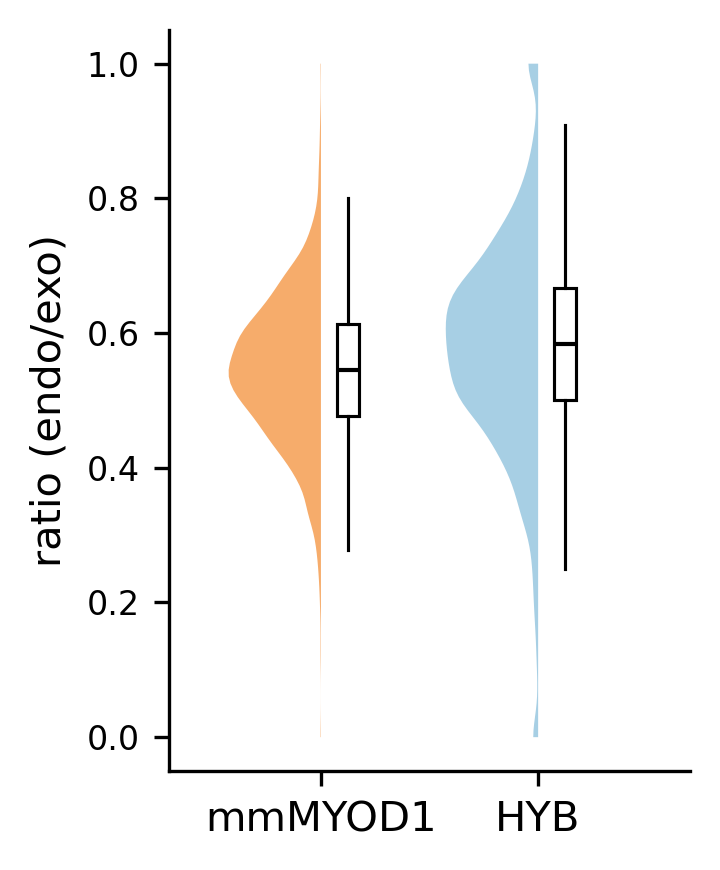

In [46]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 3

fig, ax = plt.subplots()


conditions = ['mmMYOD1', 'siPRRX1/mmMYOD1']
cond_colors = ['#F5A35B', '#9ECAE1']

violin_width = 0.85
box_width = 0.1
offset = violin_width/6 - box_width/6


for i, condition in enumerate(conditions):
    vals = plot_df.loc[plot_df['pooled_condition'] == condition, 'MYOD1_endo_exo_ratio']

    parts = ax.violinplot(
        vals,
        positions=[i],         
        widths=0.85,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for pc in parts['bodies']:
        verts = pc.get_paths()[0].vertices
        mean_x = np.mean(verts[:, 0])
        verts[:, 0] = np.minimum(verts[:, 0], mean_x)  # keep left half
        pc.set_facecolor(cond_colors[i])
        pc.set_alpha(0.9)

    # --- Boxplot (slightly right of tick) ---
    box = ax.boxplot(
        vals,
        positions=[i + offset],   # offset right
        widths=0.1,
        patch_artist=True,
        showcaps=False,
        showfliers=False,
        whiskerprops={"linewidth": 0.75},
        medianprops={"color": "black", "linewidth": 1},
        boxprops={'linewidth': 0.75},
    )
    for patch in box['boxes']:
        patch.set_facecolor('white')
        patch.set_edgecolor("black")

        
        
ax.set_xlim(-0.7, len(conditions) - 0.3)
# ax.set_ylim([-0.2, 1.2])


ax.set_xticks(range(len(conditions)))
ax.set_xticklabels(['mmMYOD1', 'HYB'])
ax.set_xlabel("")
ax.set_ylabel("ratio (endo/exo)")
plt.yticks(fontsize=8)

sns.despine()
plt.tight_layout()
plt.show()

# Load in processed gene data

In [2]:
# %%time
# # load in processed adata
# path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad"
# adata = sc.read_h5ad(path)
# sc.logging.print_memory_usage()
# adata

Memory usage: current 2.16 GB, difference +2.16 GB
CPU times: user 236 ms, sys: 1.12 s, total: 1.35 s
Wall time: 4.29 s


/nfs/turbo/umms-indikar/Jillian/conda-envs/scanpy/lib/python3.13/site-packages/anndata/logging.py:57: FutureWarning: The specified parameters ('newline',) are no longer positional. Please specify them like `newline=False`
  print(format_memory_usage(get_memory_usage(), msg, newline))


AnnData object with n_obs × n_vars = 15950 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

# Load in Exo vs Endo counts

In [3]:
# %%time
# fpath = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/data/exo_vs_endo/runs/minimap_spliced/merged_mmyod_spliced.h5ad"
# bdata = sc.read_h5ad(fpath)
# bdata

CPU times: user 85 ms, sys: 188 ms, total: 273 ms
Wall time: 758 ms


AnnData object with n_obs × n_vars = 10895 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'obs_condition_id', 'condition', 'chr11_primary', 'chr11_secondary', 'chr11_supplementary', 'chrMMYOD_primary', 'chrMMYOD_secondary', 'chrMMYOD_supplementary', 'ratio_primary', 'myod_total', 'mmyod_total', 'ratio_all', 'dpt_pseudotime', 'hour_timepoint'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'
    uns: 'assigned_condition_colors', 'diffmap_evals', 'iroot', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
# # filter for cells present in adata
# bdata.obs_names = [f"{cb}_hybrid" for cb in bdata.obs_names] # make sure cell IDs match
# bdata = bdata[bdata.obs.index.isin(adata.obs_names), :].copy()
# bdata

AnnData object with n_obs × n_vars = 8990 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'obs_condition_id', 'condition', 'chr11_primary', 'chr11_secondary', 'chr11_supplementary', 'chrMMYOD_primary', 'chrMMYOD_secondary', 'chrMMYOD_supplementary', 'ratio_primary', 'myod_total', 'mmyod_total', 'ratio_all', 'dpt_pseudotime', 'hour_timepoint'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'
    uns: 'assigned_condition_colors', 'diffmap_evals', 'iroot', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# # create cell ID -- exo vs endo mapping
# myod_df = bdata.obs[['myod_total', 'mmyod_total']].copy()
# myod_df = myod_df.rename(columns={'myod_total': 'MYOD1_endo', 'mmyod_total': 'MYOD1_exo'})

# print(myod_df.shape)
# myod_df.head()

(8990, 2)


,MYOD1_endo,MYOD1_exo
AAACCAAAGCAACTGC_hybrid,50.0,93.0
AAACCAAAGTAGGGCA_hybrid,22.0,43.0
AAACCAAAGTCTAGGC_hybrid,24.0,35.0
AAACCATTCACGTAAT_hybrid,0.0,0.0
AAACCATTCAGGCAGA_hybrid,0.0,0.0


# Merge into adata

In [6]:
# n_cells = adata.shape[0]
# all_cells = adata.obs_names.tolist()

# # Create zero arrays for the two new genes
# myod1_endo_counts = np.zeros(n_cells, dtype=int)
# myod1_exo_counts  = np.zeros(n_cells, dtype=int)

# # Map adata cell names to index
# cell_to_idx = {cell: idx for idx, cell in enumerate(all_cells)}

# # Fill counts for hybrid cells 
# for cell in myod_df.index:
#     if cell in cell_to_idx:
#         idx = cell_to_idx[cell]
#         myod1_endo_counts[idx] = myod_df.loc[cell, 'MYOD1_endo']
#         myod1_exo_counts[idx]  = myod_df.loc[cell, 'MYOD1_exo']
        
# myod_counts_matrix = np.stack([myod1_endo_counts, myod1_exo_counts], axis=1)  # (15950, 2)
# print(myod_counts_matrix.shape)

(15950, 2)


In [7]:
# if sp.issparse(adata.layers['raw_counts']):
#     raw_counts_dense = adata.layers['raw_counts'].toarray()
# else:
#     raw_counts_dense = np.array(adata.layers['raw_counts'])

# print('Shapes:', raw_counts_dense.shape, myod_counts_matrix.shape)

Shapes: (15950, 25042) (15950, 2)


In [8]:
# raw_counts_new = np.concatenate([raw_counts_dense, myod_counts_matrix], axis=1)
# print('New shape:', raw_counts_new.shape)

New shape: (15950, 25044)


In [9]:
# new_var_names = list(adata.var_names) + ['MYOD1_endo', 'MYOD1_exo']

# new_var_df = pd.concat(
#     [adata.var.copy(), pd.DataFrame(index=['MYOD1_endo', 'MYOD1_exo'])]
# )


# adata_expanded = an.AnnData(
#     X = np.zeros((adata.n_obs, len(new_var_names)), dtype=float),  # Dummy, just needs right shape
#     obs = adata.obs.copy(),
#     var = new_var_df
# )

# for key in adata.layers.keys():
#     # Expand each layer with 2 zero columns to match new genes
#     arr = adata.layers[key]
#     arr = arr.toarray() if hasattr(arr, "toarray") else np.array(arr)  # handle sparse
#     arr_expanded = np.concatenate([arr, np.zeros((adata.n_obs, 2), dtype=arr.dtype)], axis=1)
#     adata_expanded.layers[key] = arr_expanded

# # 4. Add your new raw_counts layer
# adata_expanded.layers['raw_counts_new'] = raw_counts_new

# # Double check the shapes:
# print("adata_expanded shape:", adata_expanded.shape)
# print("raw_counts_new shape:", raw_counts_new.shape)
# print("adata_expanded.var_names:", adata_expanded.var_names[-5:])  # Show last 5 gene names

# # Add UMAP coordinates
# adata_expanded.obsm['X_umap'] = adata.obsm['X_umap'].copy()
# adata_expanded

adata_expanded shape: (15950, 25044)
raw_counts_new shape: (15950, 25044)
adata_expanded.var_names: Index(['ZYX', 'ZZEF1', 'ZZZ3', 'MYOD1_endo', 'MYOD1_exo'], dtype='object')


AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [10]:
# # Check that counts are > 0
# print(f"Counts for Endo and Exo MYOD1: {adata_expanded[:, ['MYOD1_endo', 'MYOD1_exo']].layers['raw_counts_new'].sum(axis=0)}\n")

# ### Add var identifiers for new genes
# # check MYOD1 entries
# display(adata_expanded.var.loc[['MYOD1', 'MYOD1_endo', 'MYOD1_exo']])

# # copy the info from the canonical MYOD1 entry
# original_gene = 'MYOD1'
# target_columns = ['gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo']

# for new_gene in ['MYOD1_endo', 'MYOD1_exo']:
#     for col in target_columns:
#         adata_expanded.var.loc[new_gene, col] = adata_expanded.var.loc[original_gene, col]
        
# # check MYOD1 entries
# print("\nUpdated var:\n")
# display(adata_expanded.var.loc[['MYOD1', 'MYOD1_endo', 'MYOD1_exo']])

Counts for Endo and Exo MYOD1: [100890. 178520.]



,gene_id,gene_type,Chromosome,Start,End,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,...,total_counts,log1p_total_counts,n_counts,filter_pass,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
MYOD1,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,5749.0,1.419532,0.883574,...,27414.0,10.218845,23753.0,True,True,146.0,0.463419,0.609542,1.273341,1.0
MYOD1_endo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYOD1_exo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Updated var:



,gene_id,gene_type,Chromosome,Start,End,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,...,total_counts,log1p_total_counts,n_counts,filter_pass,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
MYOD1,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,5749.0,1.419532,0.883574,...,27414.0,10.218845,23753.0,True,True,146.0,0.463419,0.609542,1.273341,1.0
MYOD1_endo,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYOD1_exo,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# # Normalize expression and plot
# adata_expanded.X = adata_expanded.layers['raw_counts_new'].copy()


# sc.pp.calculate_qc_metrics(
#     adata_expanded,
#     layer='raw_counts_new',
#     inplace=True,
# )

# sc.pp.normalize_total(
#     adata_expanded,
#     target_sum=1e4,
# )

# adata_expanded.layers['norm'] = adata_expanded.X.copy()

# # log transform normalized counts
# sc.pp.log1p(adata_expanded)

# # save log normalized counts
# adata_expanded.layers['log_norm'] = adata_expanded.X.copy()

# adata_expanded

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [37]:
# display(adata_expanded.var.loc[['MYOD1', 'MYOD1_endo', 'MYOD1_exo']])

,gene_id,gene_type,Chromosome,Start,End,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,...,total_counts,log1p_total_counts,n_counts,filter_pass,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
MYOD1,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,4987,1.489028,0.911892,...,23750.0,10.075380,23753.0,True,True,146.0,0.463419,0.609542,1.273341,1.0
MYOD1_endo,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,5774,6.325392,1.991347,...,100890.0,11.521796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYOD1_exo,ENSG00000129152,protein_coding,chr11,17719570.0,17722136.0,False,False,5993,11.192476,2.500819,...,178520.0,12.092462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MYOD1_endo,5774,6.325392,1.991347,63.799373,100890.0,11.521796
MYOD1_exo,5993,11.192476,2.500819,62.426332,178520.0,12.092462


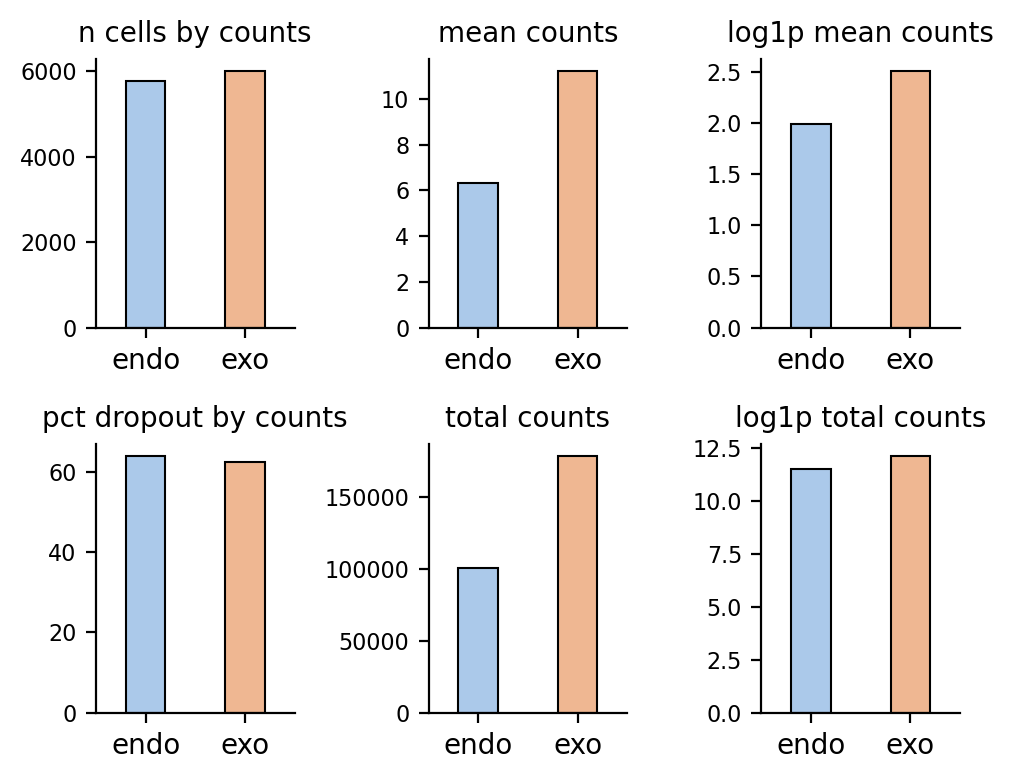

In [58]:
vdf = adata_expanded.var.loc[['MYOD1_endo', 'MYOD1_exo']].copy()

vdf = vdf[['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']]

display(vdf)


plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(2, 3)

for i, col in enumerate(vdf.columns):
    ax = axs[i // 3, i % 3]
    plot_data = vdf[[col]].reset_index().rename(columns={'index': 'Gene', col: 'Value'})
    
    sns.barplot(
        data=plot_data,
        x='Gene',
        y='Value',
        hue='Gene',
        ax=ax,
        palette='pastel',
        legend=False,
        width=0.4,
        ec='k',
        linewidth=0.75,
    )
    
    ax.set_title(col.replace('_', ' '), fontsize=10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(['endo', 'exo'])
    ax.tick_params(axis='y', labelsize=8)

sns.despine()
plt.tight_layout()
plt.show()

... storing 'gene_id' as categorical


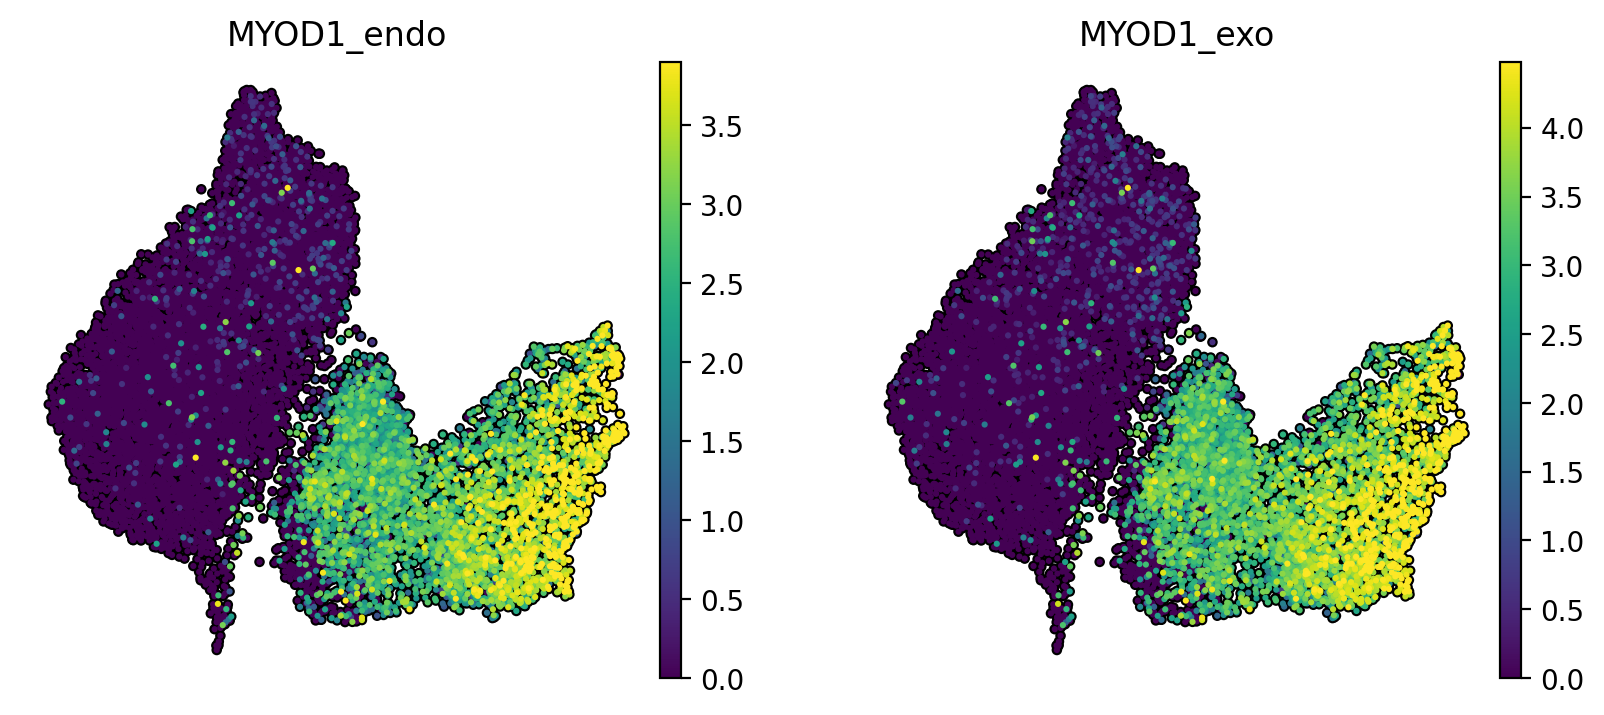

In [59]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    adata_expanded,
    color=['MYOD1_endo', 'MYOD1_exo'],
    size=20,
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    layer='log_norm',
    vmin='p2',
    vmax='p98',
)

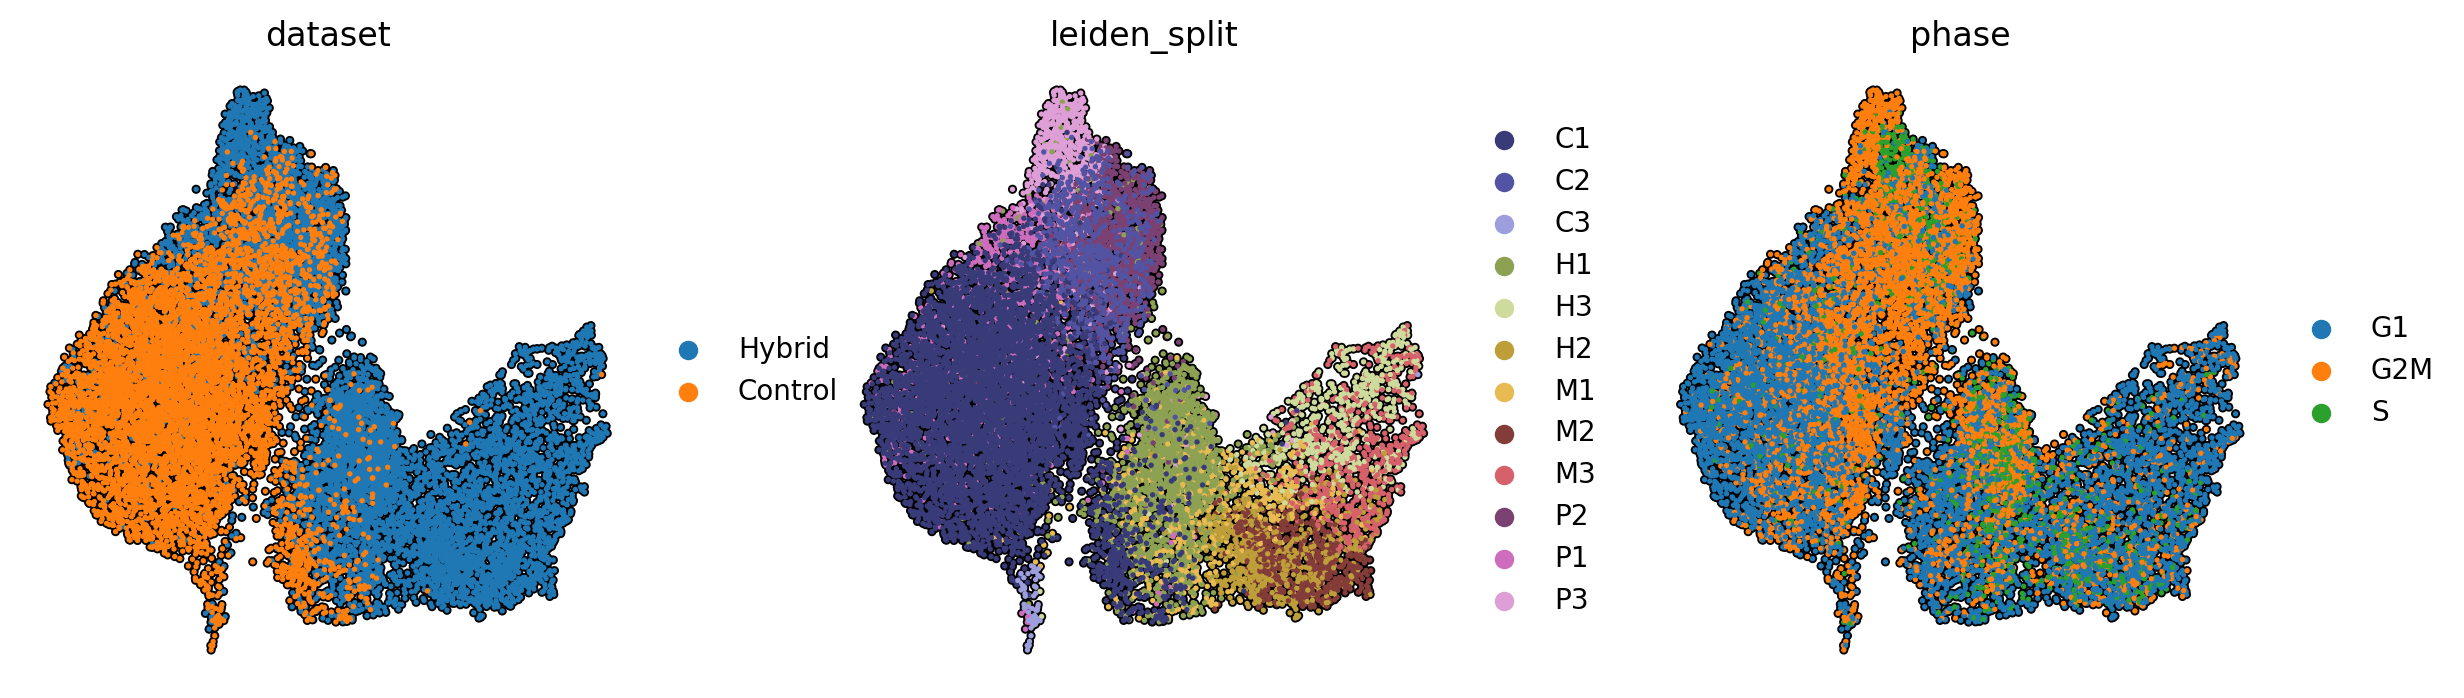

In [72]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

adata_expanded.uns['leiden_split_colors'] = adata.uns['leiden_split_colors'].copy()

sc.pl.umap(
    adata_expanded,
    color=['dataset', 'leiden_split', 'phase'],
    size=15,
    ncols=3,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

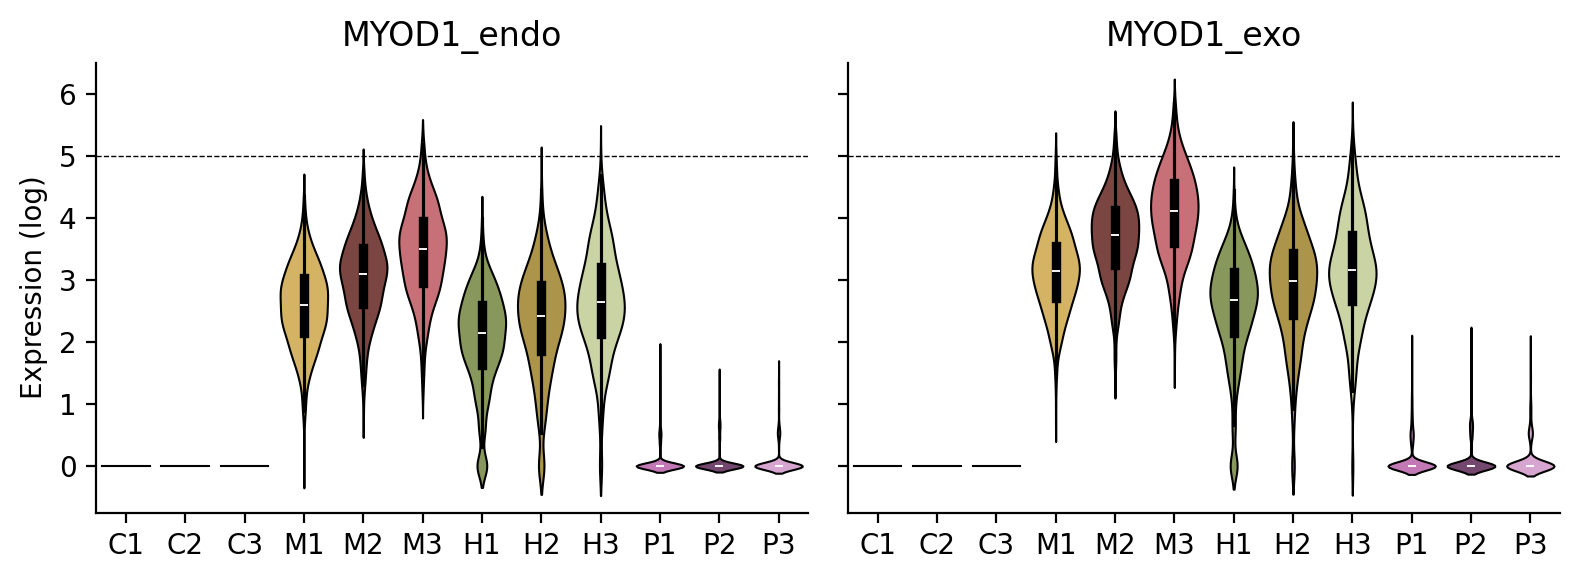

In [71]:
genes_to_plot = ['MYOD1_endo', 'MYOD1_exo']

plot_order = ["C1","C2","C3",
              "M1","M2","M3",
              "H1","H2","H3",
              "P1","P2","P3"]

palette = adata.uns['leiden_split_colors']

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200, sharey=True)

layer = 'log_norm'

for i, gene in enumerate(genes_to_plot):
    adata_expanded.X = adata_expanded.layers[layer].copy()
    gene_exp = adata_expanded[:, gene].X.toarray().flatten()
    groups = adata_expanded.obs['leiden_split']
    data = pd.DataFrame({'expression': gene_exp, 'group': groups})

    sns.violinplot(
        data=data,
        x='group',
        y='expression',
        hue='group',
        order=plot_order,
        linewidth=0.75,
        linecolor='k',
        palette=palette,
        ax=axes[i],
        legend=False,
    )
    axes[i].set_xlabel("")
    
    if layer == 'log_norm':
        axes[i].set_ylabel("Expression (log)")
        axes[i].axhline(y=5, ls='--', color='k', lw=0.5, zorder=0)
    else:
        axes[i].set_ylabel("Raw counts")
    axes[i].set_title(gene)
    axes[i].set_ylim([-0.75, 6.5])
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

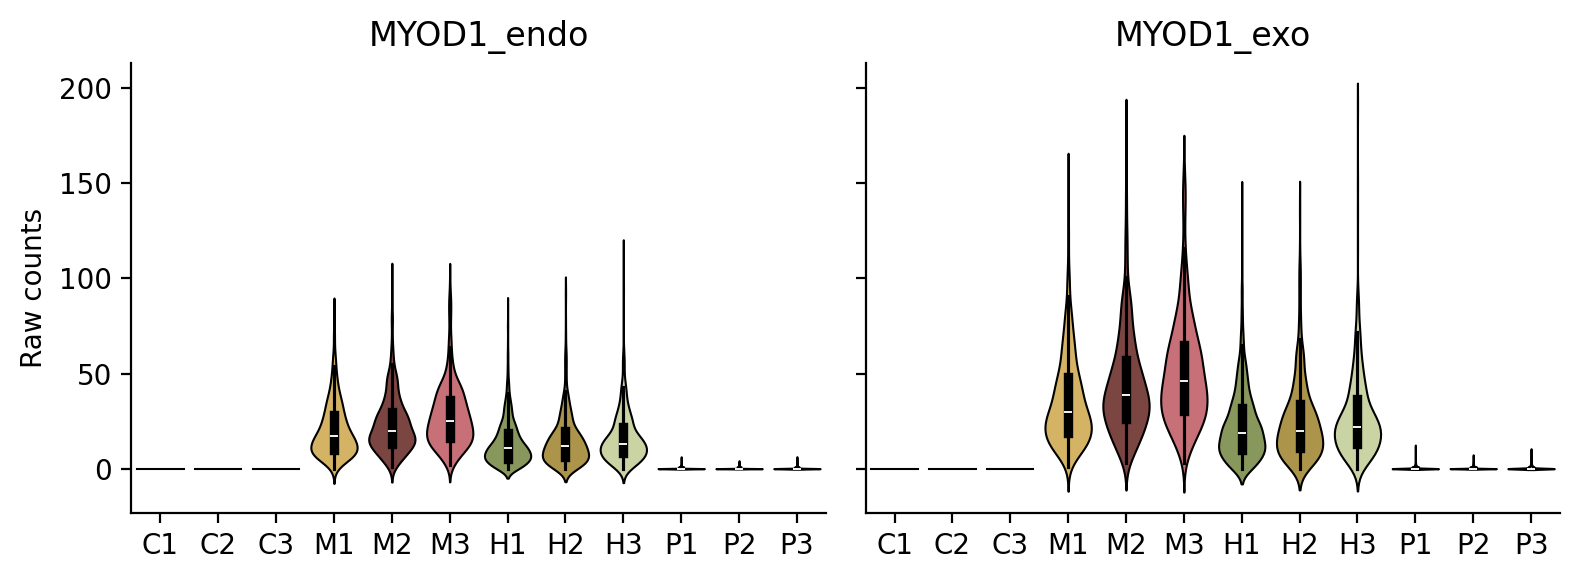

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200, sharey=True)

layer = 'raw_counts_new'

for i, gene in enumerate(genes_to_plot):
    adata_expanded.X = adata_expanded.layers[layer].copy()
    gene_exp = adata_expanded[:, gene].X.toarray().flatten()
    groups = adata_expanded.obs['leiden_split']
    data = pd.DataFrame({'expression': gene_exp, 'group': groups})

    sns.violinplot(
        data=data,
        x='group',
        y='expression',
        hue='group',
        order=plot_order,
        linewidth=0.75,
        linecolor='k',
        palette=palette,
        ax=axes[i],
        legend=False,
    )
    axes[i].set_xlabel("")
    
    if layer == 'log_norm':
        axes[i].set_ylabel("Expression (log)")
        axes[i].axhline(y=5, ls='--', color='k', lw=0.5, zorder=0)
    else:
        axes[i].set_ylabel("Raw counts")
    axes[i].set_title(gene)
    # axes[i].set_ylim([-0.75, 6.5])
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

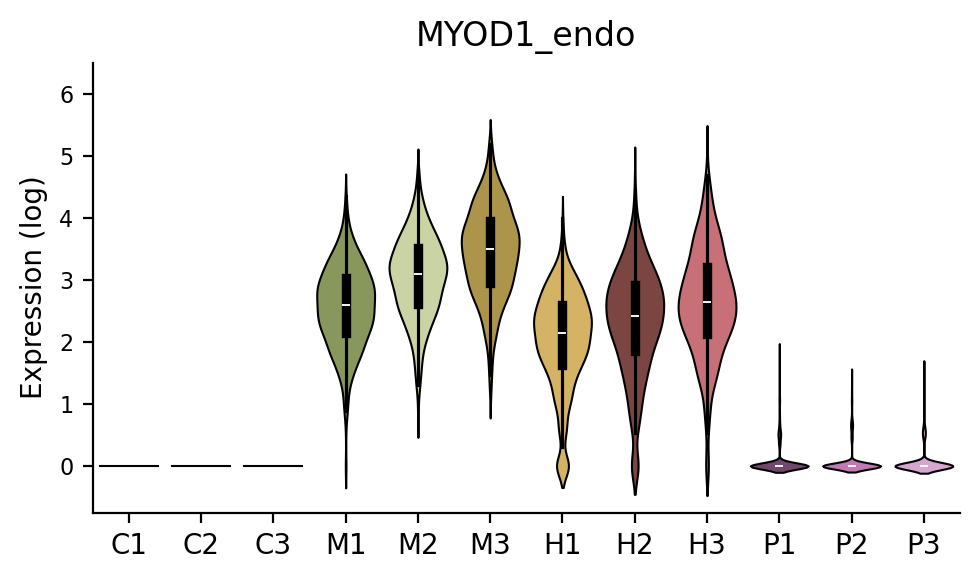

In [60]:
# gene_to_plot = 'MYOD1_endo'

# adata_expanded.X = adata_expanded.layers["log_norm"].copy()

# gene_exp = adata_expanded[:, gene_to_plot].X.toarray().flatten()
# groups = adata_expanded.obs['leiden_split']

# data = pd.DataFrame({'expression': gene_exp, 'group': groups})

# plot_order = ["C1","C2","C3",
#               "M1","M2","M3",
#               "H1","H2","H3",
#               "P1","P2","P3"]


# palette = adata.uns['leiden_split_colors']

# plt.rcParams['figure.figsize'] = 5, 3
# plt.rcParams['figure.dpi'] = 200

# sns.violinplot(
#     data=data,
#     x='group',
#     y='expression',
#     hue='group',
#     order=plot_order,
#     hue_order=plot_order,
#     linewidth=0.75,
#     linecolor='k',
#     palette=palette,
#     # palette=color_map,
#     legend=False,
# )


# plt.xlabel("")
# plt.yticks(fontsize=8)
# plt.ylabel("Expression (log)")
# plt.title(f"{gene_to_plot}")
# plt.ylim([-0.75, 6.5])

# sns.despine()
# plt.tight_layout()
# plt.show()

In [75]:
genes_to_plot = ['MYOD1_endo', 'MYOD1_exo', 'PRRX1']

avg_expr = pd.DataFrame(index=genes_to_plot, columns=plot_order)
pct_expr = pd.DataFrame(index=genes_to_plot, columns=plot_order)

adata_expanded.X = adata_expanded.layers['log_norm'].copy()

for g in plot_order:
    cells = adata_expanded.obs['leiden_split'] == g
    data = adata_expanded[cells, genes_to_plot].X
    # If sparse matrix
    if not isinstance(data, np.ndarray):
        data = data.toarray()
    avg_expr[g] = data.mean(axis=0)
    pct_expr[g] = (data > 0).mean(axis=0) * 100
    
# Z-score by gene
avg_expr = avg_expr.T   
avg_expr_z = avg_expr.apply(scipy.stats.zscore, axis=0)
avg_expr_z = avg_expr_z.T

print(pct_expr.shape)
print(avg_expr_z.shape)
avg_expr_z.head()

(3, 12)
(3, 12)


,C1,C2,C3,M1,M2,M3,H1,H2,H3,P1,P2,P3
MYOD1_endo,-0.995360,-0.995360,-0.995360,0.888725,1.236564,1.534485,0.502898,0.716229,0.947873,-0.944895,-0.949298,-0.946500
MYOD1_exo,-1.009187,-1.009187,-1.009187,0.907170,1.241529,1.482070,0.544181,0.751405,0.927524,-0.943105,-0.943536,-0.939677
PRRX1,1.376557,1.718952,1.191533,0.536944,0.721307,-0.573574,-0.887502,-0.832290,-1.401524,-0.674324,-0.556139,-0.619939


In [77]:
pct_expr.head()

,C1,C2,C3,M1,M2,M3,H1,H2,H3,P1,P2,P3
MYOD1_endo,0.000000,0.000000,0.000000,99.716714,100.000000,100.000000,95.145631,96.749025,98.713826,11.578045,9.151194,10.052910
MYOD1_exo,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,96.213592,98.439532,99.356913,16.380789,14.588859,15.343915
PRRX1,83.415597,92.839806,75.862069,69.830028,66.392318,33.234421,33.980583,31.209363,11.414791,42.195540,41.644562,41.402116


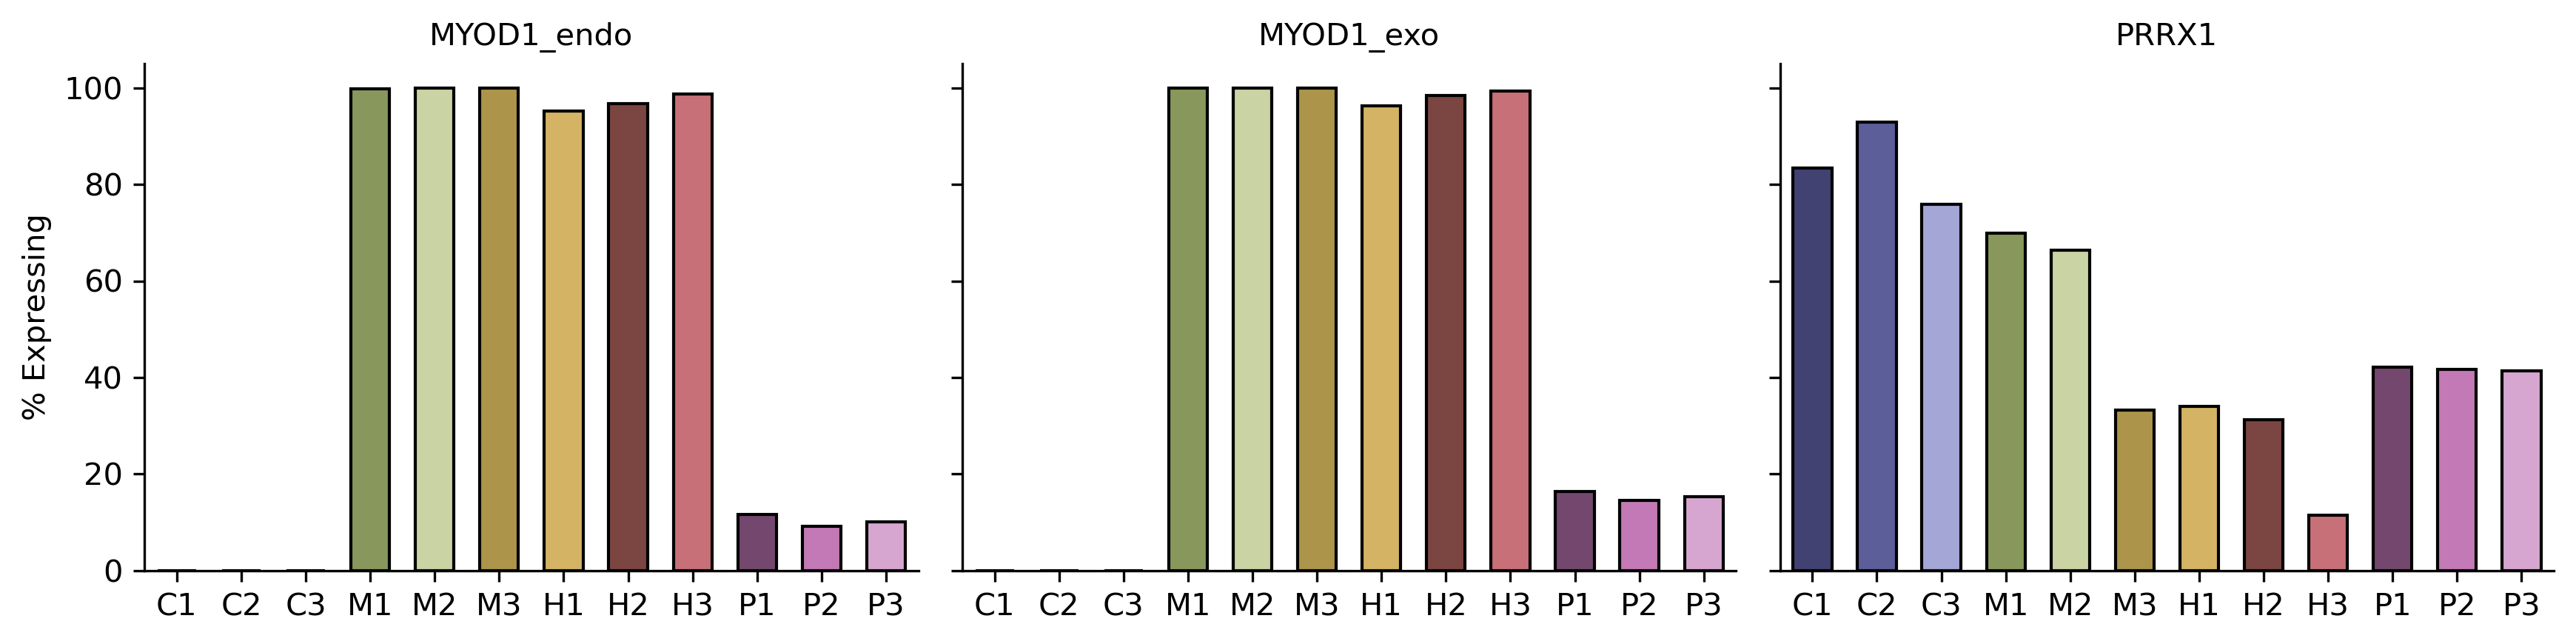

In [76]:
plot_df = pct_expr.reset_index().melt(id_vars='index', var_name='Cluster', value_name='% Expressing')
plot_df.rename(columns={'index': 'Gene'}, inplace=True)

plt.rcParams['figure.dpi'] = 300

g = sns.FacetGrid(plot_df, col="Gene", sharey=True, height=3, aspect=1.3)
g.map_dataframe(
    sns.barplot, 
    x="Cluster", 
    y="% Expressing", 
    palette=palette,#"Blues",
    ec='k',
    hue="Cluster",
    legend=False,
    width=0.6,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "% Expressing")
g.tight_layout()
plt.show()

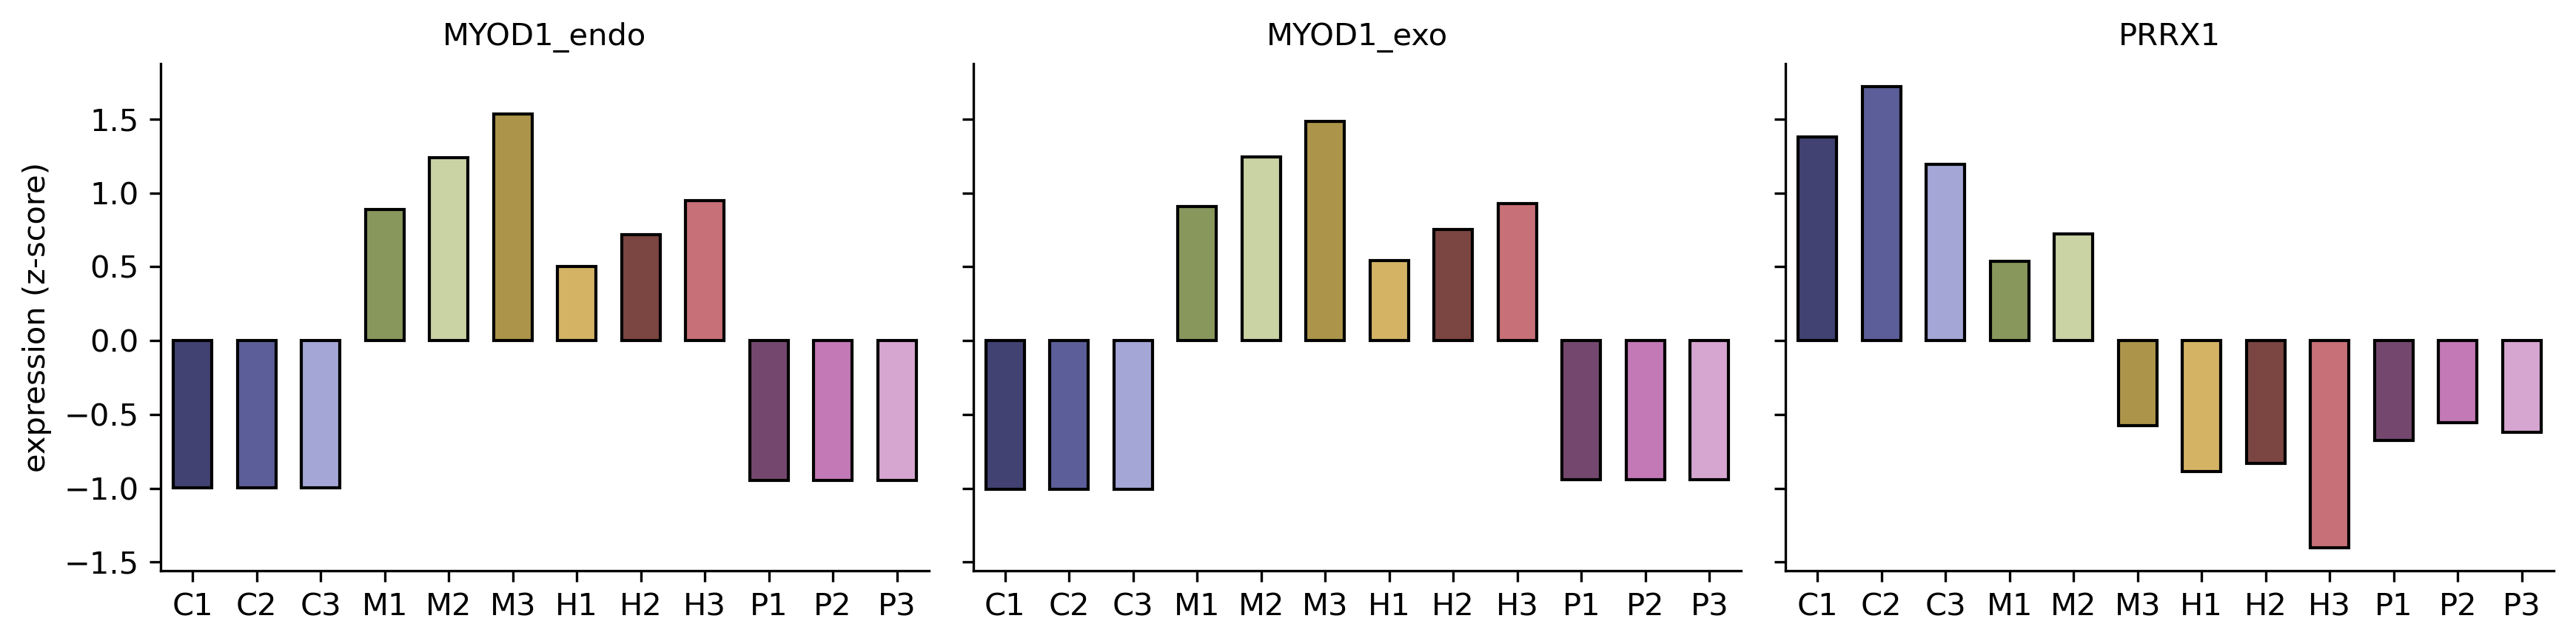

In [78]:
plot_df = avg_expr_z.reset_index().melt(id_vars='index', var_name='Cluster', value_name='expression (z-score)')
plot_df.rename(columns={'index': 'Gene'}, inplace=True)

plt.rcParams['figure.dpi'] = 300

g = sns.FacetGrid(plot_df, col="Gene", sharey=True, height=3, aspect=1.3)
g.map_dataframe(
    sns.barplot, 
    x="Cluster", 
    y="expression (z-score)", 
    palette=palette,#"Blues",
    ec='k',
    hue="Cluster",
    legend=False,
    width=0.6,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "expression (z-score)")
g.tight_layout()
plt.show()

(3, 12)


,C1,C2,C3,M1,M2,M3,H1,H2,H3,P1,P2,P3
MYOD1_endo,0.000000,0.000000,0.0,81.019830,93.689986,97.626113,57.233010,69.700910,80.546624,0.000000,0.000000,0.0
MYOD1_exo,0.000000,0.000000,0.0,95.609065,98.902606,99.703264,79.029126,85.045514,92.122186,0.000000,0.066313,0.0
PRRX1,2.221125,0.849515,0.0,1.416431,2.057613,0.445104,0.048544,0.260078,0.160772,0.085763,0.066313,0.0


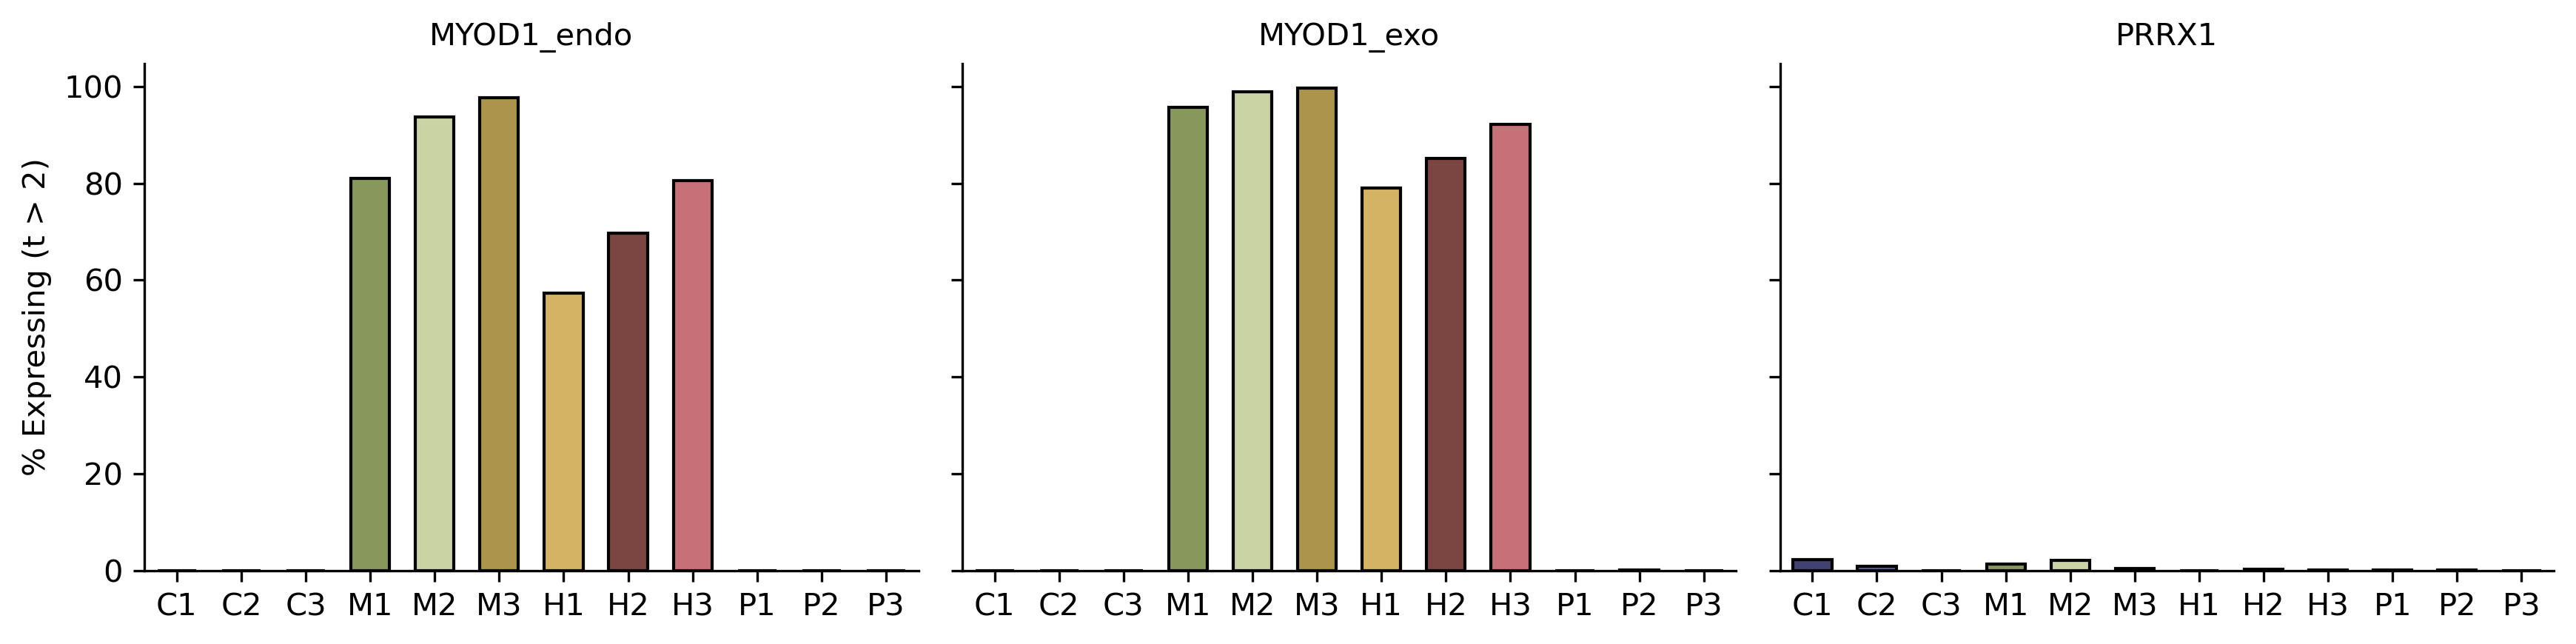

In [83]:
# pct expressing above a threshold

threshold = 2

genes_to_plot = ['MYOD1_endo', 'MYOD1_exo', 'PRRX1']

pct_expr = pd.DataFrame(index=genes_to_plot, columns=plot_order)

adata_expanded.X = adata_expanded.layers['log_norm'].copy()

for g in plot_order:
    cells = adata_expanded.obs['leiden_split'] == g
    data = adata_expanded[cells, genes_to_plot].X
    # If sparse matrix
    if not isinstance(data, np.ndarray):
        data = data.toarray()
        
    pct_expr[g] = (data > threshold).mean(axis=0) * 100

print(pct_expr.shape)
display(pct_expr.head())


plot_df = pct_expr.reset_index().melt(id_vars='index', var_name='Cluster', value_name='% Expressing')
plot_df.rename(columns={'index': 'Gene'}, inplace=True)

plt.rcParams['figure.dpi'] = 300

g = sns.FacetGrid(plot_df, col="Gene", sharey=True, height=3, aspect=1.3)
g.map_dataframe(
    sns.barplot, 
    x="Cluster", 
    y="% Expressing", 
    palette=palette,#"Blues",
    ec='k',
    hue="Cluster",
    legend=False,
    width=0.6,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", f"% Expressing (t > {threshold})")
g.tight_layout()
plt.show()

count    5993.000000
mean        0.565769
std         0.190281
min         0.000000
25%         0.481481
50%         0.566667
75%         0.660714
max         1.000000
Name: MYOD1_endo_exo_ratio, dtype: float64

(15950, 37)
(5993, 37)


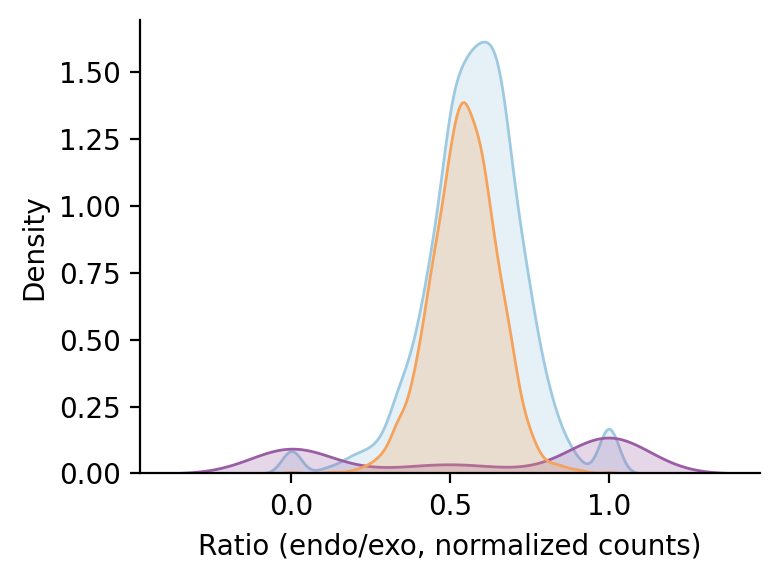

In [121]:
# compute ratio of exo and endo

endo_idx = adata_expanded.var_names.get_loc('MYOD1_endo')
exo_idx  = adata_expanded.var_names.get_loc('MYOD1_exo')


layer = 'norm'

expr = adata_expanded.layers[layer]
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

endo_exp = expr[:, endo_idx]
exo_exp  = expr[:, exo_idx]

# Calculate ratio safely (NaN where exo is 0)
ratio = np.divide(endo_exp, exo_exp, out=np.full_like(endo_exp, np.nan), where=exo_exp!=0)

adata_expanded.obs['MYOD1_endo_exo_ratio'] = ratio

# display(adata_expanded.obs.head())
display(adata_expanded.obs['MYOD1_endo_exo_ratio'].describe())



plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

df = adata_expanded.obs.copy()
print(df.shape)
df = adata_expanded.obs.dropna(subset='MYOD1_endo_exo_ratio')
print(df.shape)

sns.kdeplot(
    # data=adata_expanded.obs,
    data=df,
    x='MYOD1_endo_exo_ratio',
    fill=True,
    hue='pooled_condition',
    palette=adata.uns['pooled_condition_colors'],
    legend=False,
)

plt.xlabel("Ratio (endo/exo, normalized counts)")

sns.despine()
plt.tight_layout()
plt.show()

(15950, 36)
(5993, 36)


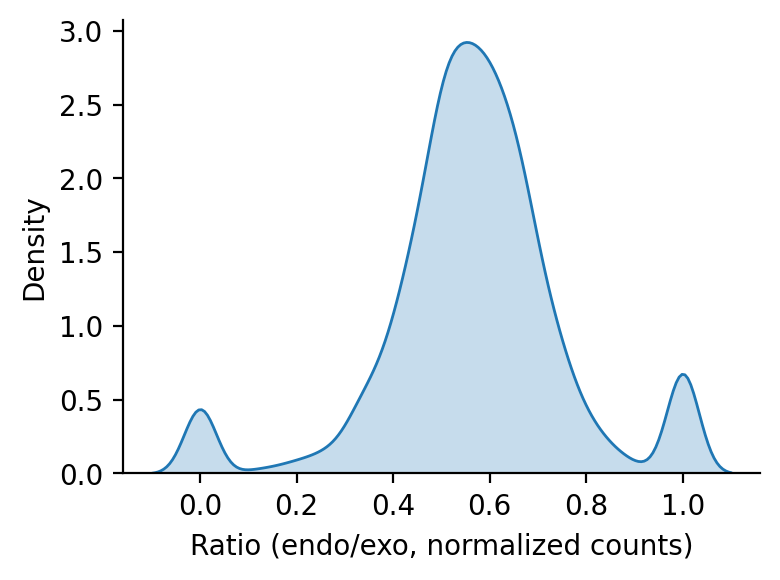

In [105]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 3

# df = adata_expanded.obs.copy()
# print(df.shape)
# df = adata_expanded.obs.dropna(subset='MYOD1_endo_exo_ratio')
# print(df.shape)

# sns.kdeplot(
#     # data=adata_expanded.obs,
#     data=df,
#     x='MYOD1_endo_exo_ratio',
#     fill=True,
#     hue='pooled_condition',
#     palette=adata.uns['pooled_condition_colors'],
# )

# plt.xlabel("Ratio (endo/exo, normalized counts)")

# sns.despine()
# plt.tight_layout()
# plt.show()

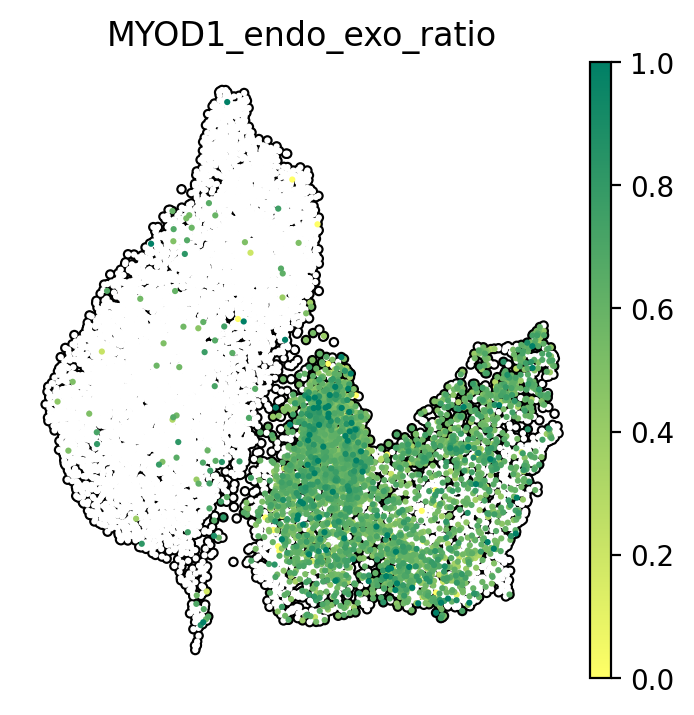

In [104]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# mask = adata_expanded.obs['pooled_condition'] == 'mmMYOD1'
mask = adata_expanded.obs['pooled_condition'] == 'siPRRX1/mmMYOD1'

sc.pl.umap(
    adata_expanded,
    color='MYOD1_endo_exo_ratio',
    mask_obs=mask,
    size=20,
    ncols=1,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    cmap='summer_r',
    na_color='white',
    # layer='log_norm',
    # vmin='p2',
    # vmax='p98',
)

count    15950.000000
mean        -0.196848
std          0.296020
min         -2.532881
25%         -0.431628
50%          0.000000
75%          0.000000
max          0.000000
Name: MYOD1_endo_exo_logdiff, dtype: float64

(15950, 37)
(5993, 37)


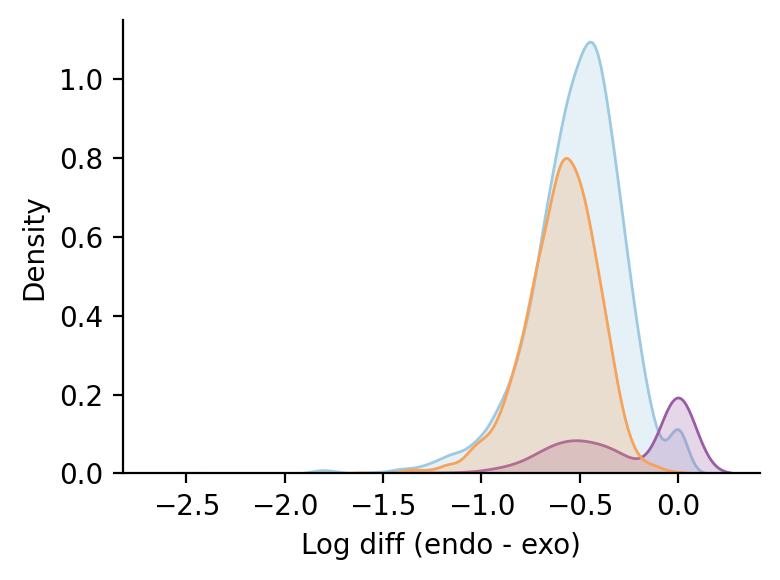

In [148]:
# log fold changes
log_norm = adata_expanded.layers['log_norm']
if not isinstance(log_norm, np.ndarray):
    log_norm = log_norm.toarray()

log_endo = log_norm[:, endo_idx]
log_exo  = log_norm[:, exo_idx]

log_fold_change = log_endo - log_exo
adata_expanded.obs['MYOD1_endo_exo_logdiff'] = log_fold_change
display(adata_expanded.obs['MYOD1_endo_exo_logdiff'].describe())


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

df = adata_expanded.obs.copy()
print(df.shape)
df = df.dropna(subset='MYOD1_endo_exo_ratio')
print(df.shape)

sns.kdeplot(
    # data=adata_expanded.obs,
    data=df,
    x='MYOD1_endo_exo_logdiff',
    hue='pooled_condition',
    palette=adata.uns['pooled_condition_colors'],
    fill=True,
    legend=False,
)

plt.xlabel("Log diff (endo - exo)")

sns.despine()
plt.tight_layout()
plt.show()

(15950, 37)
(5993, 37)


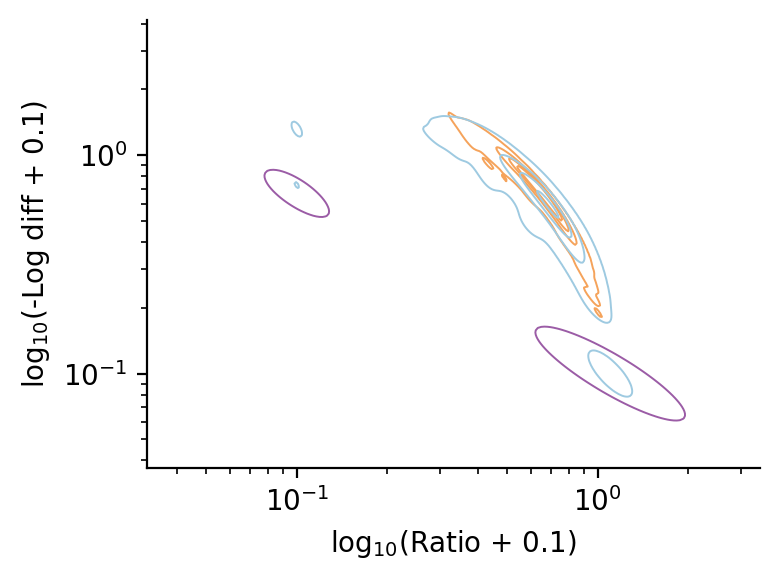

In [147]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

df = adata_expanded.obs.copy()
print(df.shape)
df = df.dropna(subset='MYOD1_endo_exo_ratio')
print(df.shape)

pseudocount = 0.1

# df['logdiff_pos'] = -df['MYOD1_endo_exo_logdiff'] # flip sign to positive for plotting
# df['logdiff_log'] = np.log10(df['logdiff_pos'] + pseudocount) # log scale

# df['ratio_log'] = np.log10(df['MYOD1_endo_exo_ratio'] + pseudocount)

df['logdiff_plot'] = -df['MYOD1_endo_exo_logdiff'] + pseudocount
df['ratio_plot'] = df['MYOD1_endo_exo_ratio'] + pseudocount

df.head()

sns.kdeplot(
    data=df,
    # x='MYOD1_endo_exo_ratio',
    # y='MYOD1_endo_exo_logdiff',
    # x='ratio_log',
    # y='logdiff_log',
    x='ratio_plot',
    y='logdiff_plot',
    hue='pooled_condition',
    palette=adata.uns['pooled_condition_colors'],
    legend=False,
    linewidths=0.7,
    alpha=1,
    log_scale=True,
    levels=5,
    # fill=True,
    # multiple='layer',
)


plt.ylabel('log$_{10}$(-Log diff + 0.1)')
plt.xlabel('log$_{10}$(Ratio + 0.1)')

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# Which cells have high endo counts?
# identify these, create .csv for mapping/incorporating into other analyses

#

# Load in all alignments

In [37]:
bam_path = "/scratch/indikar_root/indikar1/jrcwycy/HYB/realignment/test_myod_aln.coord.bam"
idx_path = bam_path + ".bai"

refs_to_check = ["MYOD1_native_full", "MYOD1_native_CDSonly", "MYOD1_modRNA_CDS_ER"]
modref = "MYOD1_modRNA_CDS_ER"
er_start, er_end = 517, 1479

bam = pysam.AlignmentFile(bam_path, "rb", index_filename=idx_path)
records = []

for ref in refs_to_check:
    for read in bam.fetch(ref, until_eof=True):
        # classify alignment type
        if read.is_supplementary:
            aln_type = "supplementary"
        elif read.is_secondary:
            aln_type = "secondary"
        else:
            aln_type = "primary"

        # softclips and sequence-dependent info
        if read.query_sequence is not None:
            seq = read.query_sequence
            qual = read.query_qualities or []
            sc_left = sc_right = 0
            if read.cigar:
                if read.cigar[0][0] == 4: sc_left = read.cigar[0][1]
                if read.cigar[-1][0] == 4: sc_right = read.cigar[-1][1]

            seq_len = len(seq)
            meanQ = sum(qual)/len(qual) if qual else np.nan
        else:
            seq_len = np.nan
            meanQ = np.nan
            sc_left = np.nan
            sc_right = np.nan

        # initialize ER overlap columns
        overlap_type = np.nan
        ref_start = np.nan
        ref_end = np.nan

        # only calculate ER overlap for reads aligned to modRNA
        if ref == modref and read.query_sequence is not None:
            aligned_blocks = read.get_reference_positions(full_length=False)
            if aligned_blocks:
                ref_start_calc = min(aligned_blocks)
                ref_end_calc = max(aligned_blocks)

                if ref_end_calc >= er_start-1 and ref_start_calc <= er_end-1:
                    # classify as full vs partial overlap
                    if ref_start_calc <= er_start-1 and ref_end_calc >= er_end-1:
                        overlap_type = "full_ER_overlap"
                    else:
                        overlap_type = "partial_ER_overlap"

                    # store 1-based coordinates
                    ref_start = ref_start_calc + 1
                    ref_end = ref_end_calc + 1

        records.append({
            "read_name": read.query_name,
            "ref_name": ref,
            "alignment_type": aln_type,
            "mapping_quality": read.mapping_quality,
            "len": seq_len,
            "meanQ": meanQ,
            "softclip_L": sc_left,
            "softclip_R": sc_right,
            "CIGAR": read.cigarstring,
            "overlap_type": overlap_type,
            "ref_start": ref_start,
            "ref_end": ref_end
        })

bam.close()

all_reads_df = pd.DataFrame(records)
print(f"Loaded {len(all_reads_df)} alignments across target references.")
print(all_reads_df["alignment_type"].value_counts())
print(all_reads_df.shape)
print(f"N unique reads: {all_reads_df['read_name'].nunique()}")
all_reads_df.head()

Loaded 344569 alignments across target references.
alignment_type
primary          313493
supplementary     30956
secondary           120
Name: count, dtype: int64
(344569, 12)
N unique reads: 313493


,read_name,ref_name,alignment_type,mapping_quality,len,meanQ,softclip_L,softclip_R,CIGAR,overlap_type,ref_start,ref_end
0,fb50ed86-1c53-4a39-aafc-443ca96784b3,MYOD1_native_full,secondary,0,NaN,NaN,NaN,NaN,72S7M1D12M1D25M3I1M2D6M1D39M269S,NaN,NaN,NaN
1,fbfc57ae-fb83-4339-800b-b4b48f1a33b7,MYOD1_native_full,secondary,0,NaN,NaN,NaN,NaN,83S35M2D51M1D17M315S,NaN,NaN,NaN
2,9ccc4f17-a318-4a24-9c0b-d33851f247e2,MYOD1_native_full,secondary,0,NaN,NaN,NaN,NaN,97S21M1D1M3I15M1D17M3D24M1D50M1D12M263S,NaN,NaN,NaN
3,0d7ab014-9b24-4cd4-8c8f-5812307da0a3,MYOD1_native_full,secondary,0,NaN,NaN,NaN,NaN,103S94M262S,NaN,NaN,NaN
4,1d68f311-7082-4dd3-9225-254c1ccb6603,MYOD1_native_full,secondary,0,NaN,NaN,NaN,NaN,87S33M4D10M1D46M259S,NaN,NaN,NaN


# Alignment types

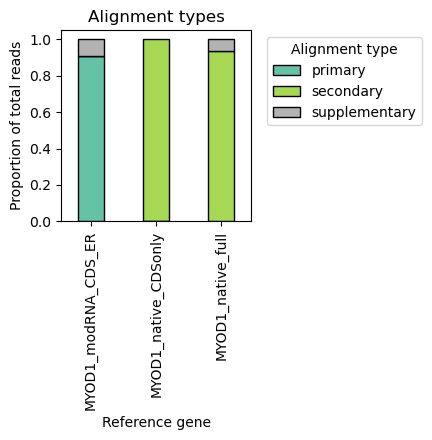

In [38]:
counts = all_reads_df.groupby(['ref_name', 'alignment_type']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot
proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(4.5,4.5),
    colormap='Set2',
    width=0.4,
    ec='k',
)

plt.ylabel('Proportion of total reads')
plt.xlabel('Reference gene')
plt.title('Alignment types')
plt.legend(title='Alignment type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [53]:
n_reads_native = all_reads_df[all_reads_df['ref_name'] == 'MYOD1_native_full']['read_name'].nunique()
print(n_reads_native)

46


# Reads spanning ER

In [42]:
er_reads = all_reads_df[all_reads_df['overlap_type'].notna()]

print(er_reads.shape)
print(f"N unique reads that overlap ER sequence: {er_reads['read_name'].nunique()}\n")
print(er_reads['overlap_type'].value_counts())

(31762, 12)
N unique reads that overlap ER sequence: 29394

overlap_type
partial_ER_overlap    31698
full_ER_overlap          64
Name: count, dtype: int64


In [49]:
total_er_reads = all_reads_df[all_reads_df['ref_name'] == 'MYOD1_modRNA_CDS_ER']['read_name'].nunique()
print(total_er_reads)

total_er_overlap = all_reads_df[all_reads_df['overlap_type'].notna()]['read_name'].nunique()
print(total_er_overlap)

n_full_overlap = all_reads_df[all_reads_df['overlap_type'] == 'full_ER_overlap']['read_name'].nunique()
print(n_full_overlap)

n_partial_overlap = all_reads_df[all_reads_df['overlap_type'] == 'partial_ER_overlap']['read_name'].nunique()
print(n_partial_overlap)

n_no_overlap = total_er_reads - (n_full_overlap + n_partial_overlap)
print(n_no_overlap)

313493
29394
64
29334
284095


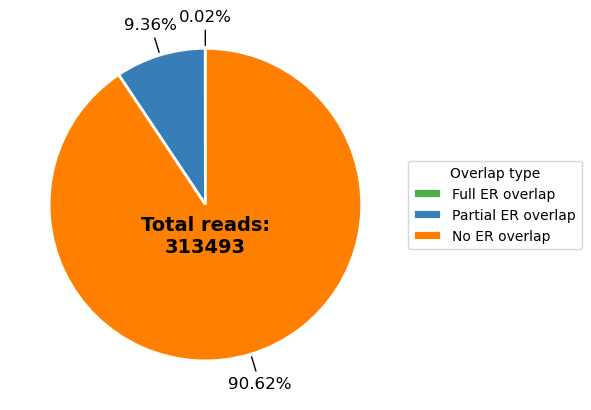

In [67]:
sizes = [n_full_overlap, n_partial_overlap, n_no_overlap]
labels = ['Full ER overlap', 'Partial ER overlap', 'No ER overlap']
colors = ['#4daf4a','#377eb8','#ff7f00']

fig, ax = plt.subplots(figsize=(6,6))

wedges, _ = ax.pie(
    sizes,
    labels=None,  # remove labels from slices
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor':'white', 'linewidth': 2},
    radius=1
)

# Place percentages outside with leader lines starting at edge
for i, wedge in enumerate(wedges):
    # mid angle of the wedge
    angle = (wedge.theta2 + wedge.theta1) / 2
    angle_rad = np.deg2rad(angle)

    # start point at wedge edge (radius = 1)
    x_start = np.cos(angle_rad)
    y_start = np.sin(angle_rad)

    # end point for text slightly outside (radius = 1.2)
    x_end = 1.2 * np.cos(angle_rad)
    y_end = 1.2 * np.sin(angle_rad)

    # draw line from wedge edge to text
    ax.annotate(f'{sizes[i]/sum(sizes)*100:.2f}%',
                xy=(x_start, y_start),
                xytext=(x_end, y_end),
                ha='center',
                va='center',
                fontsize=12,
                arrowprops=dict(arrowstyle='-', color='black'))

# Add legend
ax.legend(wedges, labels, title="Overlap type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))#, fontsize=12)
# Add total reads in center
ax.text(0, -0.2, f'Total reads:\n{total_er_reads}', ha='center', va='center', fontsize=14, fontweight='bold')

# ax.set_title('Distribution of modRNA reads by ER overlap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## soft-clip ends

In [68]:
er_reads.head()

,read_name,ref_name,alignment_type,mapping_quality,len,meanQ,softclip_L,softclip_R,CIGAR,overlap_type,ref_start,ref_end
98,0a1a6099-cefd-42ad-a18c-e05407b56c59,MYOD1_modRNA_CDS_ER,primary,60,1461.0,24.022587,133.0,738.0,133S14M2D27M1D179M1I268M2D15M5D55M1I7M1D23M738S,partial_ER_overlap,1.0,599.0
100,0a1f3665-79f7-402b-950d-c443fb242cff,MYOD1_modRNA_CDS_ER,primary,60,828.0,30.373188,122.0,110.0,122S14M2D193M1D389M110S,partial_ER_overlap,1.0,599.0
116,0a06f68e-0613-4336-bc67-c412daa14806,MYOD1_modRNA_CDS_ER,primary,60,845.0,34.648521,137.0,110.0,137S14M2D391M3D151M1I41M110S,partial_ER_overlap,1.0,602.0
119,0a7ef609-18cc-4df3-8756-5560312a3fe8,MYOD1_modRNA_CDS_ER,primary,60,2255.0,33.055432,109.0,233.0,109S14M3D85M1D123M1I7M1I2M1D2M1I4M1D31M1D233M3...,full_ER_overlap,1.0,1926.0
134,0a16b12c-a3d3-4765-98f8-f49ae5853e8e,MYOD1_modRNA_CDS_ER,primary,60,944.0,31.796610,128.0,290.0,128S14M3D475M1I2M1I5M1D10M5I4M1I8M290S,partial_ER_overlap,1.0,522.0


2096


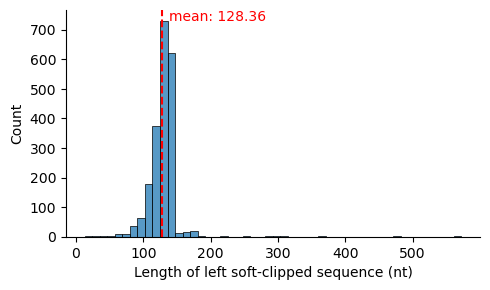

In [90]:
tmp = er_reads[(er_reads['alignment_type'] == 'primary') & (er_reads['meanQ'] >= 30) & (er_reads['ref_start'] == 1)]
print(tmp['read_name'].nunique())

mean_length = tmp['softclip_L'].mean()
median_length = tmp['softclip_L'].median()


fig, ax = plt.subplots(figsize=(5,3))

sns.histplot(
    data=tmp,
    x='softclip_L',
    bins=50,
)

plt.axvline(x=mean_length, ls='--', c='r')
plt.text(x=mean_length+10, y=730, s=f'mean: {mean_length:.2f}', c='r') 

plt.xlabel("Length of left soft-clipped sequence (nt)")

sns.despine()
plt.tight_layout()
plt.show()

In [79]:
print(tmp['softclip_L'].mean())
print(tmp['softclip_L'].median())

128.36068702290078
132.0


# Estimating 5' UTR

In [40]:
# Trying to assess what the 5' UTR is 

# filter for quality / length
tmp = er_reads[(er_reads['meanQ'] >= 30) & (er_reads['ref_start'] == 1) & (er_reads['softclip_L'] >= 30)]
print(len(tmp))

# extract left softclips
l_softclips = []

for read_id in tmp['read_name']:
    read = next(b for b in bam.fetch(modref) if b.query_name == read_id)
    seq = read.query_sequence
    cigar = read.cigar
    if cigar and cigar[0][0] == 4:
        sc_len = cigar[0][1]
        l_softclips.append(seq[:sc_len])
        
        
# ---- right-align softclips ----
max_len = max(len(s) for s in l_softclips)
aligned_matrix = []

for s in l_softclips:
    # pad left with gaps so right ends align
    padded = '-' * (max_len - len(s)) + s
    aligned_matrix.append(list(padded))
    
# ---- generate consensus from right to left ----
consensus = []
for col in range(max_len):
    column_bases = [row[col] for row in aligned_matrix if row[col] != '-']
    if not column_bases:
        consensus.append('N')
        continue
    c = Counter(column_bases)
    # pick majority base
    base, count = c.most_common(1)[0]
    # optional: if majority < 50%, mark N
    if count / len(column_bases) < 0.5:
        consensus.append('N')
    else:
        consensus.append(base)

consensus_seq = ''.join(consensus)
print("Approximate 5' UTR sequence (right-aligned to ER junction):")
print(consensus_seq)

2095
Approximate 5' UTR sequence (right-aligned to ER junction):
ATCTACGTGTACCTCGTTCAGTTGCGTATTGCTTGCTGATATTGCAAGCAGTGGTATCAACGCAGAGTACATGGGCCCCCCCGAGGCCGAGGGCTTCCCCAACACCATCGGCGCCGCCGCCGCCTTCTACCCGGCCCCCTGCCCCCGGCCGGGGCGGCGAGCACTACAGCGGCGACAGCGACGCCAGCAGCCCCCAGAGCAACTNANGTNTTGNTNTGNTTTCCTNTNGTGCTCCTCCNGGCNNNNCCNGGNGNNGCAACGGATAGTACACNGGNTACTNCNNNNNNGCATNNCGNACTCCGGNCANNCNNNCNNNNCGCCNNCNNNTNNNNNNGNTNNCNNAGGNNGNNGANNTNNNNNNNCNNGNNNNNNGCNNNGNNNNCCANCNNNNNNNNNNNNNNTTNTNNNTNNNNNNTNNNNNNNNNNNNNNTNNTTTTTTTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTNTTTNNNNNNNNNTTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGGGGGNAAAAGAGAGAAAAGAAGAGTAAGAAGAAATATAAGAGCCACC


In [50]:
l_softclips = [s.upper() for s in l_softclips if s]

if len(l_softclips) == 0:
    raise ValueError("No soft-clip sequences found in l_softclips")

# Reverse sequences so ER junction is at left (anchor)
rev_seqs = [s[::-1] for s in l_softclips]

# Start consensus as the longest reversed read
consensus = max(rev_seqs, key=len)

def align_and_merge(consensus, seq):
    """
    Align consensus and seq (both orientation reversed) using difflib.SequenceMatcher,
    produce gapped aligned strings, and merge into a new consensus string.
    """
    sm = SequenceMatcher(None, consensus, seq, autojunk=False)
    a_aligned = []
    b_aligned = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'equal':
            a_aligned.append(consensus[i1:i2])
            b_aligned.append(seq[j1:j2])
        elif tag == 'replace':
            # replace: take both substrings, pad the shorter with gaps to align
            a_sub = consensus[i1:i2]
            b_sub = seq[j1:j2]
            L = max(len(a_sub), len(b_sub))
            a_aligned.append(a_sub + '-' * (L - len(a_sub)))
            b_aligned.append(b_sub + '-' * (L - len(b_sub)))
        elif tag == 'delete':
            # present in consensus, gap in seq
            a_sub = consensus[i1:i2]
            a_aligned.append(a_sub)
            b_aligned.append('-' * len(a_sub))
        elif tag == 'insert':
            # gap in consensus, present in seq
            b_sub = seq[j1:j2]
            a_aligned.append('-' * len(b_sub))
            b_aligned.append(b_sub)
    # join
    a_str = ''.join(a_aligned)
    b_str = ''.join(b_aligned)

    # Merge column-wise to make new consensus
    merged = []
    for ac, bc in zip(a_str, b_str):
        if ac == bc and ac != '-':
            merged.append(ac)
        elif ac == '-':
            merged.append(bc)
        elif bc == '-':
            merged.append(ac)
        else:
            # mismatch: choose majority base later; for now put 'N' placeholder
            merged.append('N')
    # remove leading/trailing gaps if any (they shouldn't matter for reversed orientation)
    merged_str = ''.join(merged).strip('-')
    return merged_str

# Progressive alignment: align each sequence into the consensus
for seq in rev_seqs:
    if seq == consensus:
        continue
    consensus = align_and_merge(consensus, seq)

# consensus is reversed orientation (right now left end is ER junction).
# Now decide trimming length: use 75th percentile of original soft-clip lengths
cutoff_len = int(np.percentile([len(s) for s in l_softclips], 75))
# Ensure we don't exceed actual consensus length
cutoff_len = min(cutoff_len, len(consensus))

# Take the leftmost cutoff_len bases (because leftmost is near ER junction in reversed seq)
trimmed_rev_consensus = consensus[:cutoff_len]

# Reverse back to normal orientation (so right end corresponds to ER junction)
final_consensus = trimmed_rev_consensus[::-1]

print(f"Consensus length (trimmed to 75th percentile = {cutoff_len}): {len(final_consensus)}")
print("Consensus (5' -> 3', right end adjacent to ER junction):")
print(final_consensus)

# OPTIONAL: produce simple per-column support statistics
# Reconstruct aligned matrix of sequences against the final consensus to show support per base
# Align each reversed seq to trimmed_rev_consensus using SequenceMatcher and build columns
aligned_matrix = []
for seq in rev_seqs:
    sm = SequenceMatcher(None, trimmed_rev_consensus, seq, autojunk=False)
    a_cols = []
    b_cols = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'equal':
            a_cols.append(trimmed_rev_consensus[i1:i2])
            b_cols.append(seq[j1:j2])
        elif tag == 'replace':
            a_sub = trimmed_rev_consensus[i1:i2]
            b_sub = seq[j1:j2]
            L = max(len(a_sub), len(b_sub))
            a_cols.append(a_sub + '-' * (L - len(a_sub)))
            b_cols.append(b_sub + '-' * (L - len(b_sub)))
        elif tag == 'delete':
            a_sub = trimmed_rev_consensus[i1:i2]
            a_cols.append(a_sub)
            b_cols.append('-' * len(a_sub))
        elif tag == 'insert':
            b_sub = seq[j1:j2]
            a_cols.append('-' * len(b_sub))
            b_cols.append(b_sub)
    a_str = ''.join(a_cols)
    # Now map a_str positions to final_consensus positions after reversing
    # We only need the sequence for the consensus orientation; so store a_str
    # Pad/truncate to cutoff_len
    a_str = a_str[:cutoff_len].ljust(cutoff_len, '-')
    # convert to forward orientation (reverse) for display if needed
    aligned_matrix.append(a_str[::-1])  # store in forward orientation

# aligned_matrix rows are sequences aligned to final_consensus (forward orientation)
# You can convert this to a DataFrame or plot as before.

Consensus length (trimmed to 75th percentile = 137): 137
Consensus (5' -> 3', right end adjacent to ER junction):
CANCACCGACGACTTCTACGACGACCCCTGCTTCAAAGAAGAGNAGAAGAAAANAGAAANANNNTAANAGAATGTCAAGTTNAGNANATAANANNNNTNNNANNAGNCGNTNNANNANNNNNGANCNNCCANNNNCN


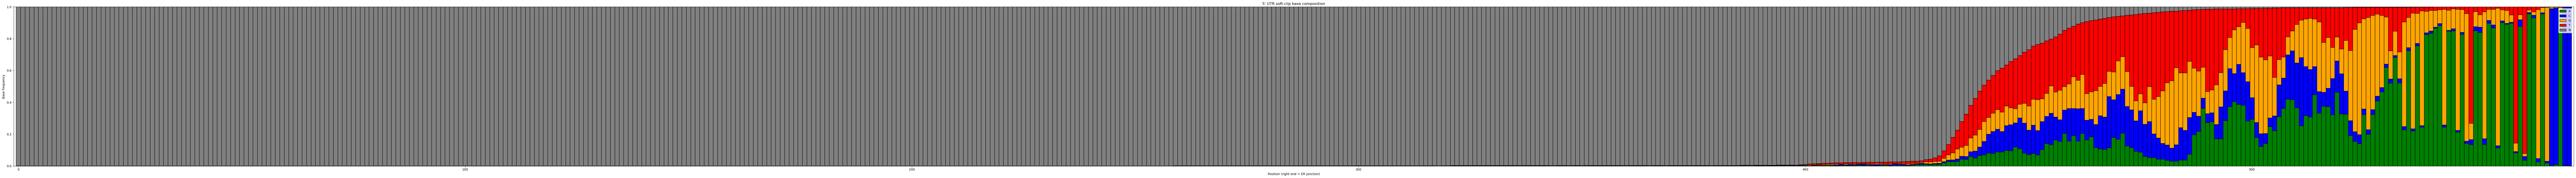

In [43]:
max_len = len(aligned_matrix[0])
bases = ['A', 'C', 'G', 'T', 'N']

# ---- compute frequencies per column ----
freq_matrix = np.zeros((len(bases), max_len))

for col in range(max_len):
    column_bases = [row[col] if row[col] in bases else 'N' for row in aligned_matrix]
    c = Counter(column_bases)
    total = sum(c.values())
    for i, b in enumerate(bases):
        freq_matrix[i, col] = c.get(b, 0) / total
        
fig, ax = plt.subplots(figsize=(max_len*0.2, 8))

bottom = np.zeros(max_len)
colors = {'A':'green','C':'blue','G':'orange','T':'red','N':'grey'}

for i, b in enumerate(bases):
    ax.bar(range(max_len), freq_matrix[i], bottom=bottom, color=colors[b], width=1.0, edgecolor='black', label=b)
    bottom += freq_matrix[i]

ax.set_xlabel("Position (right end = ER junction)")
ax.set_ylabel("Base frequency")
ax.set_title("5' UTR soft-clip base composition")
ax.set_xlim([-1, max_len])
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
all_reads_df['ref_name'].value_counts()

ref_name
MYOD1_modRNA_CDS_ER     344475
MYOD1_native_full           47
MYOD1_native_CDSonly        47
Name: count, dtype: int64

In [28]:
native = all_reads_df[(all_reads_df['ref_name'] == 'MYOD1_native_full') & (all_reads_df['alignment_type'] == 'supplementary')]
native.head()

,read_name,ref_name,alignment_type,mapping_quality,len,meanQ,softclip_L,softclip_R,CIGAR
39,b6f968c6-8b53-4669-b1e9-b96b2646fd63,MYOD1_native_full,supplementary,0,52.0,37.211538,0.0,0.0,740H52M162H
45,1c4bcb88-7958-4a91-bb62-665471b715a3,MYOD1_native_full,supplementary,0,71.0,23.971831,0.0,0.0,83H21M1D50M835H
46,985a909a-8ba2-4bd6-82dd-bae41a8e4aa2,MYOD1_native_full,supplementary,0,56.0,22.892857,0.0,0.0,93H48M1I7M295H


In [29]:
read_id = 'b6f968c6-8b53-4669-b1e9-b96b2646fd63'

tmp = all_reads_df[all_reads_df['read_name'] == read_id]
tmp

,read_name,ref_name,alignment_type,mapping_quality,len,meanQ,softclip_L,softclip_R,CIGAR
39,b6f968c6-8b53-4669-b1e9-b96b2646fd63,MYOD1_native_full,supplementary,0,52.0,37.211538,0.0,0.0,740H52M162H
86,b6f968c6-8b53-4669-b1e9-b96b2646fd63,MYOD1_native_CDSonly,secondary,0,NaN,NaN,NaN,NaN,740S52M162S
76532,b6f968c6-8b53-4669-b1e9-b96b2646fd63,MYOD1_modRNA_CDS_ER,primary,60,954.0,36.808176,66.0,227.0,66S117M1I311M1I231M227S


#

# Align

In [19]:
# Load in MYOD1 sequences
with open("MYOD1_endo_exo.txt") as f:
    lines = f.read().splitlines()
    endo_myod = lines[0].strip() # first line contains UTRs + CDS
    exo_myod = lines[1].strip() # cDNA sequence we gave to Trilink
    er_seq = lines[2].strip() # ER sequence insert
    
print(len(endo_myod))
print(len(exo_myod))
print(len(er_seq))

1803
1926
963


In [14]:
%%time
bam_path = "/scratch/indikar_root/indikar1/jrcwycy/HYB/bam_test/test_myod_reads.sorted.bam"
idx_path = "/scratch/indikar_root/indikar1/jrcwycy/HYB/bam_test/test_myod_reads.sorted.bam.bai"

bam = pysam.AlignmentFile(bam_path, "rb", index_filename=idx_path)

CPU times: user 4.69 ms, sys: 740 μs, total: 5.43 ms
Wall time: 27.5 ms


In [21]:
# initialize the aligner
aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -0.5
aligner.extend_gap_score = -0.1

# Compare each read
results = []
for read in bam.fetch():
    read_seq = read.query_sequence

    score_endogenous = aligner.score(read_seq, endo_myod)
    score_modrna = aligner.score(read_seq, exo_myod)

    best_match = "endogenous" if score_endogenous > score_modrna else "modRNA"

    results.append({
        "read_name": read.query_name,
        "score_endogenous": score_endogenous,
        "score_modrna": score_modrna,
        "best_match": best_match
    })


df = pd.DataFrame(results)
df

,read_name,score_endogenous,score_modrna,best_match
0,24c00180-b005-4640-9ccb-703a8ed006e8_0,1175.5,1291.6,modRNA
1,4cf0d91e-afff-47db-902c-d7ffcd80b428_0,1144.5,1273.8,modRNA
2,b9352761-e91f-48e3-b853-da6f24baad84_0,1209.8,1395.6,modRNA
3,5f30b54a-1394-403f-913c-a95f162131ab_0,1177.4,1368.7,modRNA
4,039a1a58-7ddb-4717-bf45-0c5a3583abea_0,689.0,807.7,modRNA
5,eb029acf-0d34-421b-9bbd-d4ea6ad424b4_0,1160.1,1162.9,modRNA
6,ab70fee5-10b6-427c-ab0a-f9b594252067_0,1087.0,1081.3,endogenous
7,24ae5696-3963-442a-8727-1cfcad58da48_0,900.0,880.1,endogenous
8,36261347-bda5-447b-aff0-34812dad470d_0,928.4,910.6,endogenous
9,818257ad-3228-4c34-b31b-5e4ce6cb1925_0,894.5,869.4,endogenous


In [20]:
# Compare each read
results = []
for read in bam.fetch():
    read_seq = read.query_sequence

    score_endogenous = aligner.score(read_seq, endo_myod)
    score_er = aligner.score(read_seq, er_seq)

    best_match = "endogenous" if score_endogenous > score_er else "modRNA"

    results.append({
        "read_name": read.query_name,
        "score_endogenous": score_endogenous,
        "score_modrna": score_modrna,
        "best_match": best_match
    })


df = pd.DataFrame(results)
df

,read_name,score_endogenous,score_modrna,best_match
0,24c00180-b005-4640-9ccb-703a8ed006e8_0,1173.6,858.5,endogenous
1,4cf0d91e-afff-47db-902c-d7ffcd80b428_0,1137.4,858.5,endogenous
2,b9352761-e91f-48e3-b853-da6f24baad84_0,1202.6,858.5,endogenous
3,5f30b54a-1394-403f-913c-a95f162131ab_0,1166.8,858.5,endogenous
4,039a1a58-7ddb-4717-bf45-0c5a3583abea_0,646.1,858.5,endogenous
5,eb029acf-0d34-421b-9bbd-d4ea6ad424b4_0,1142.8,858.5,endogenous
6,ab70fee5-10b6-427c-ab0a-f9b594252067_0,1074.8,858.5,endogenous
7,24ae5696-3963-442a-8727-1cfcad58da48_0,892.3,858.5,endogenous
8,36261347-bda5-447b-aff0-34812dad470d_0,926.4,858.5,endogenous
9,818257ad-3228-4c34-b31b-5e4ce6cb1925_0,878.4,858.5,endogenous


# Parse bam file for MYOD reads

In [3]:
%%time

path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/pipeline_outputs/hyb_epi2me_final/hybrid/hybrid.read_summary.tsv"

df = pd.read_csv(path, sep='\t')
print(df.shape)
df.head()

(154491536, 12)
CPU times: user 6min 13s, sys: 1min 16s, total: 7min 29s
Wall time: 7min 58s


,read_id,uncorrected_barcode,corrected_barcode,quality_barcode,uncorrected_umi,corrected_umi,quality_umi,gene,transcript,start,end,chr
0,cc54fe5c-2dd3-4403-b361-6ab67656ccb9_0,GTGAGTAGCTCCAGGC,GTGAGTAGTTCCAGGC,"440/..($###$&(*,",GAATGATTACAG,GAATGATTACAG,"+++,00000000",-,-,38152,38457,GL000213.1
1,b81006c2-b975-4edb-a194-cfad8c189430_0,TCCTCAACAAGCGCGT,TCCTCAACAAGCGCGT,C?D@A=<>::995334,GGCCCTTTTATT,GGCCCTTTTATT,9723221=@>?A,-,-,4620,4933,GL000213.1
2,b81006c2-b975-4edb-a194-cfad8c189430_1,TCCTCAACAAGCGCGC,TCCTCAACAAGCGCGT,<@>;9:;688;;:8:(,TGCCCTTTTATT,GGCCCTTTTATT,(4BJSHKJAJPS,-,-,4659,4943,GL000213.1
3,2a8de785-8cca-48e3-a72b-13c4520494df_0,GTGAGTAGTTCCAGGC,GTGAGTAGTTCCAGGC,99944446768:5111,GCCACGGGCTGC,GCCACGGGCTGC,33///079888:,-,-,38149,38457,GL000213.1
4,b37758e5-66bc-4a78-9294-a0170695e257_0,CAAGTCGCATGACACG,CAAGTCGCATGACACG,0BB???DFIEEGFDEF,GTGGCCTCGGGG,GTGGCCTCGGGG,IKHLA?>@O?<5,ENSG00000271254,-,7025,8731,KI270711.1


In [4]:
df['read_id'].nunique()

154491536

In [11]:
df.head(10)

,read_id,uncorrected_barcode,corrected_barcode,quality_barcode,uncorrected_umi,corrected_umi,quality_umi,gene,transcript,start,end,chr
0,cc54fe5c-2dd3-4403-b361-6ab67656ccb9_0,GTGAGTAGCTCCAGGC,GTGAGTAGTTCCAGGC,"440/..($###$&(*,",GAATGATTACAG,GAATGATTACAG,"+++,00000000",-,-,38152,38457,GL000213.1
1,b81006c2-b975-4edb-a194-cfad8c189430_0,TCCTCAACAAGCGCGT,TCCTCAACAAGCGCGT,C?D@A=<>::995334,GGCCCTTTTATT,GGCCCTTTTATT,9723221=@>?A,-,-,4620,4933,GL000213.1
2,b81006c2-b975-4edb-a194-cfad8c189430_1,TCCTCAACAAGCGCGC,TCCTCAACAAGCGCGT,<@>;9:;688;;:8:(,TGCCCTTTTATT,GGCCCTTTTATT,(4BJSHKJAJPS,-,-,4659,4943,GL000213.1
3,2a8de785-8cca-48e3-a72b-13c4520494df_0,GTGAGTAGTTCCAGGC,GTGAGTAGTTCCAGGC,99944446768:5111,GCCACGGGCTGC,GCCACGGGCTGC,33///079888:,-,-,38149,38457,GL000213.1
4,b37758e5-66bc-4a78-9294-a0170695e257_0,CAAGTCGCATGACACG,CAAGTCGCATGACACG,0BB???DFIEEGFDEF,GTGGCCTCGGGG,GTGGCCTCGGGG,IKHLA?>@O?<5,ENSG00000271254,-,7025,8731,KI270711.1
5,00e0ccc9-c50f-4ab7-a4eb-37c614924d22_0,CTCCATTAGGGGATAT,CTCCATTAGGGGATAT,NKHJSHESOISIKLQI,ACCGACGCTGGT,ACCGACGCTGGT,OGJLIGMIHD@D,-,-,31324,31606,KI270711.1
6,d41d3010-149c-47e4-b815-8aa5c99fc166_0,TGAACCACATTCAGTT,CGAACCACATTCAGTT,$%*(((5:9658?666,CATTGAGCCCAG,CATTGAGCCCAG,6CAA=8022598,-,-,37462,38426,KI270711.1
7,b37a0a4e-e5ed-4c9b-b0ed-2f229a6a4ef6_0,CGCCATGAGAAGGGTT,CGCCATGAGAAGGGTT,<?==??@FCIDBJKLS,TGCTCATACTTG,TGCTCATACTTG,H;;;;GPAAABD,ENSG00000271254,-,7045,26364,KI270711.1
8,0d979f6a-bedf-44d8-9ee0-b9d0db848c5c_0,GCGTAGCCAGCGACCA,GCGTAGCCAAGCGACC,&&&&&'-.078;<@@@,GCCTGCGCTCGT,GCCTGCGCTCGT,@>>@FDB?==<=,ENSG00000271254,-,33676,34338,KI270711.1
9,57b938d9-b2eb-407c-b4ab-c3f592b9a1a2_0,CTAGCCTCAACTACCC,CTAGCCTCAACTACCC,",5438999EGDADCBA",TATGGCGTGCGT,TATGGCGTGCGT,BA>=>>ABCBFS,ENSG00000271254,-,7045,11059,KI270711.1


In [14]:
myod_df = df[(df['gene'] == 'MYOD1') | (df['transcript'] == 'ENST00000250003')]
# myod_df = df[df['transcript'] == 'ENST00000250003']
print(myod_df.shape)
myod_df.head()

(211761, 12)


,read_id,uncorrected_barcode,corrected_barcode,quality_barcode,uncorrected_umi,corrected_umi,quality_umi,gene,transcript,start,end,chr
125775868,24ae5696-3963-442a-8727-1cfcad58da48_0,TACTTCATCTCACTAC,TACTTCATCTCACTAC,LMHCDCIHLC?=>>AA,GAGTCATTCTGA,GAGTCATTCTGA,AEBFBCEDDFES,MYOD1,ENST00000250003,17720325,17721509,chr11
125775887,24c00180-b005-4640-9ccb-703a8ed006e8_0,CGGTTTGGTCAGCTCA,CGGTTTGGTCAGCTCA,CFSHKKJMGFPMEHII,GTGCTTGCTTGA,GTGCTTGCTTGA,GNJGEGFCIECS,-,ENST00000250003,17719782,17720313,chr11
125775934,eb029acf-0d34-421b-9bbd-d4ea6ad424b4_0,AGCCAGCCAATGTCAA,AGCCAGCCAATGTCAA,LGGHFSA=>333:>D?,CCCGTTGGGAAG,CCCGTTGGGAAG,::6773667?A@,-,ENST00000250003,17720298,17721509,chr11
125776366,4cf0d91e-afff-47db-902c-d7ffcd80b428_0,ACAGTGAGTCTCACGA,ACAGTGAGTCTCACGA,A;:::<&&9'((434:,CTAGGTACGTGT,CTAGGTACGTGT,;;HIEFDDDGSS,MYOD1,ENST00000250003,17719782,17720304,chr11
125776411,818257ad-3228-4c34-b31b-5e4ce6cb1925_0,GATGGGCACAGCGACT,GGATGGGCACAGCGAC,",8:@??@BBC@IMSHE",AAACATTGTACT,AAACATTGTACT,F=SCGA@=::==,MYOD1,ENST00000250003,17720900,17721509,chr11


In [18]:
tmp = myod_df.head(10)

# myod_reads = myod_df['read_id']
myod_reads = tmp['read_id']
print(len(myod_reads))

myod_reads.to_csv(
    '/scratch/indikar_root/indikar1/jrcwycy/HYB/bam_test/test_myod_readIDs.txt',
    index=False,
    header=False,
)

10
